# India Cotton Analysis - Model Development Notebook

In [35]:
import pandas as pd
import numpy as np
import datetime
import pickle
import unicodedata

import sqlalchemy
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import re
from ipywidgets import interact, IntSlider, fixed

import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely import wkt
from shapely.prepared import prep

from scipy.optimize import minimize, curve_fit
from scipy.stats import uniform, randint
from geopy.distance import geodesic

from hmmlearn import hmm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from scikeras.wrappers import KerasClassifier, KerasRegressor

from functools import partial

warnings.filterwarnings('ignore')
np.random.seed(29)
tf.random.set_seed(29)

### Load in Data

In [197]:
path = './data/agricultural_data/cd_rel_clean_full.csv'
cd_rel_full = pd.read_csv(path)

path = './data/agricultural_data/cd_rel_clean_3ytd.csv'
cd_rel_3ytd = pd.read_csv(path)

path = './data/agricultural_data/cd_rel_clean_1ytd.csv'
cd_rel_1ytd = pd.read_csv(path)

path = './data/economic_data/cotton_prices_1990_2024.csv'
cotton_prices = pd.read_csv(path)

# `price_offset ` = -1

##### Prepare `cotton_prices`

In [201]:
price_offset = -1
cotton_prices['DATE'] = pd.to_datetime(cotton_prices['DATE'])

cotton_prices = cotton_prices[(cotton_prices['DATE'] <= pd.to_datetime('2020-01-01')) & (cotton_prices['DATE'] >= pd.to_datetime('1990-01-01'))].reset_index(drop = True)

cotton_col = 'PCOTTINDUSDM'

cotton_prices[f'{cotton_col}_next_month'] = cotton_prices[cotton_col].shift(price_offset)
cotton_prices['next_month_pct_change'] = cotton_prices.apply(lambda row : 100 * (row[[f'{cotton_col}_next_month']] - row[cotton_col]) / row[cotton_col], axis = 1)
cotton_prices = cotton_prices.dropna(subset = [f'{cotton_col}_next_month'])
cotton_prices['buy'] = (cotton_prices['next_month_pct_change'] > 0).astype(int)

##### Add price_data for `cd_rel`'s

In [204]:
col = 'buy'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = cotton_col
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = f'{cotton_col}_next_month'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = 'next_month_pct_change'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

### Model Development

In [207]:
def find_outliers(series):
    '''
    Description
    --------------------------------------------------
    Identifies outliers in a given pandas Series based 
    on the Interquartile Range (IQR) method.
    
    Inputs
    --------------------------------------------------
    + series : pandas.Series; the series for which to 
      identify outliers
    
    Outputs
    --------------------------------------------------
    + Returns a boolean series indicating True for 
      outliers and False for non-outliers.
    '''
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

**All Data**

In [210]:
### All Data
df = cd_rel_full.dropna()
X = df.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y = df['buy']

### Numeric Version of y: Price of Cotton
y_num = df[cotton_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df))
X_train, X_test = X_scaled.iloc[: train_boundary, :], X_scaled.iloc[train_boundary :, :]
y_train, y_test = y.iloc[: train_boundary], y.iloc[train_boundary :]

y_num_train, y_num_test = y_num.iloc[: train_boundary], y_num.iloc[train_boundary :]

**Outlier Exclusive**

In [213]:
### Outlier Exclusive
### Gets rid of outliers
col = 'next_month_pct_change'

outliers_idx = find_outliers(df[col])

df_no_outliers = df[~outliers_idx].reset_index()


X_no_outliers = df_no_outliers.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y_no_outliers = df_no_outliers['buy']

### Numeric Version of y: Price of Cotton
y_num_no_outliers = df_no_outliers[cotton_col]

scaler = StandardScaler()
X_scaled_no_outliers = pd.DataFrame(scaler.fit_transform(X_no_outliers))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df_no_outliers))
X_train_no_outliers, X_test_no_outliers = X_scaled_no_outliers.iloc[: train_boundary, :], X_scaled_no_outliers.iloc[train_boundary :, :]
y_train_no_outliers, y_test_no_outliers = y_no_outliers.iloc[: train_boundary], y_no_outliers.iloc[train_boundary :]

y_num_train_no_outliers, y_num_test_no_outliers = y_num_no_outliers.iloc[: train_boundary], y_num_no_outliers.iloc[train_boundary :]

**Spike Exclusive**

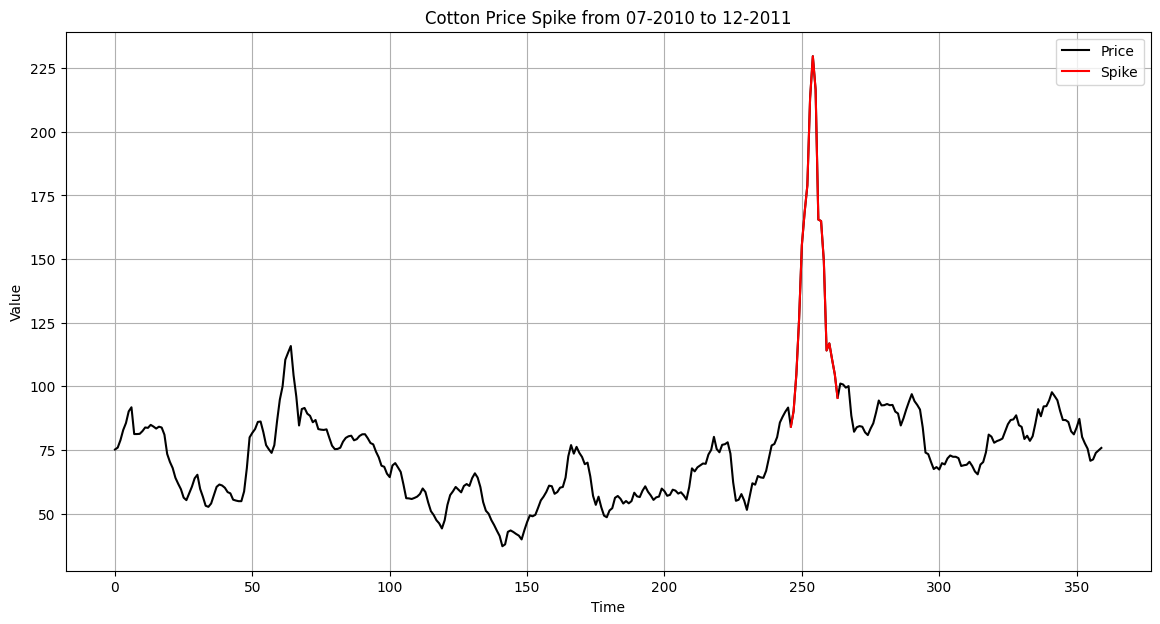

In [216]:
spike = df.iloc[246:264]
spike_idx = spike.index
plt.figure(figsize=(14, 7))

plt.plot(df.index, df[cotton_col], label='Price', color='black')

plt.plot(spike.index, spike[cotton_col], label='Spike', color='red')

plt.title(f"Cotton Price Spike from {spike['month'].values[0]:02}-{spike['year'].values[0]:02} to {spike['month'].values[-1]:02}-{spike['year'].values[-1]:02}")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [217]:
df_no_spike = df[~df.index.isin(spike_idx)]


X_no_spike = df_no_spike.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y_no_spike = df_no_spike['buy']

### Numeric Version of y: Price of Cotton
y_num_no_spike = df_no_spike[cotton_col]

scaler = StandardScaler()
X_scaled_no_spike = pd.DataFrame(scaler.fit_transform(X_no_spike))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df_no_spike))
X_train_no_spike, X_test_no_spike = X_scaled_no_spike.iloc[: train_boundary, :], X_scaled_no_spike.iloc[train_boundary :, :]
y_train_no_spike, y_test_no_spike = y_no_spike.iloc[: train_boundary], y_no_spike.iloc[train_boundary :]

y_num_train_no_spike, y_num_test_no_spike = y_num_no_spike.iloc[: train_boundary], y_num_no_spike.iloc[train_boundary :]

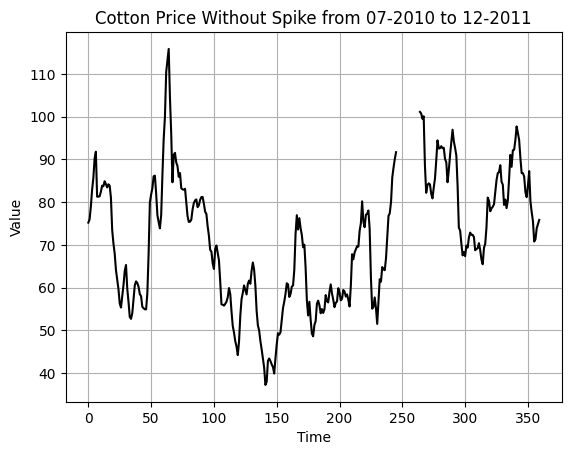

In [220]:
plt.plot(df_no_spike.loc[:spike_idx[0]].index, df_no_spike.loc[:spike_idx[0], cotton_col], color='black')

plt.plot(df_no_spike.loc[spike_idx[-1]:].index, df_no_spike.loc[spike_idx[-1]:,cotton_col], color='black')

plt.title(f"Cotton Price Without Spike from {spike['month'].values[0]:02}-{spike['year'].values[0]:02} to {spike['month'].values[-1]:02}-{spike['year'].values[-1]:02}")
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## All Data

#### Basic Regression

##### Strategy I: Direct Classification (Logistic Regression)

In [225]:
remove_outliers = False
remove_spike = False

if remove_outliers:
    train_boundary = int((1 - test_size) * len(df_no_outliers))
    reg_df = df_no_outliers
    reg_X_train = X_train_no_outliers
    reg_y_train = y_train_no_outliers
    reg_y_num_train = y_num_train_no_outliers
    
    reg_X_test = X_test_no_outliers
    reg_y_test = y_test_no_outliers
    reg_y_num_test = y_num_test_no_outliers
else:
    train_boundary = int((1 - test_size) * len(df))
    reg_df = df
    reg_X_train = X_train
    reg_y_train = y_train
    reg_y_num_train = y_num_train
    
    reg_X_test = X_test
    reg_y_test = y_test
    reg_y_num_test = y_num_test
    
if remove_spike:
    train_boundary = int((1 - test_size) * len(df_no_spike))
    reg_df = df_no_spike
    reg_X_train = X_train_no_spike
    reg_y_train = y_train_no_spike
    reg_y_num_train = y_num_train_no_spike
    
    reg_X_test = X_test_no_spike
    reg_y_test = y_test_no_spike
    reg_y_num_test = y_num_test_no_spike

In [227]:
log_reg = LogisticRegression(random_state = 29)

log_reg.fit(reg_X_train, reg_y_train)

y_pred_proba = log_reg.predict_proba(reg_X_test)[:, 1]

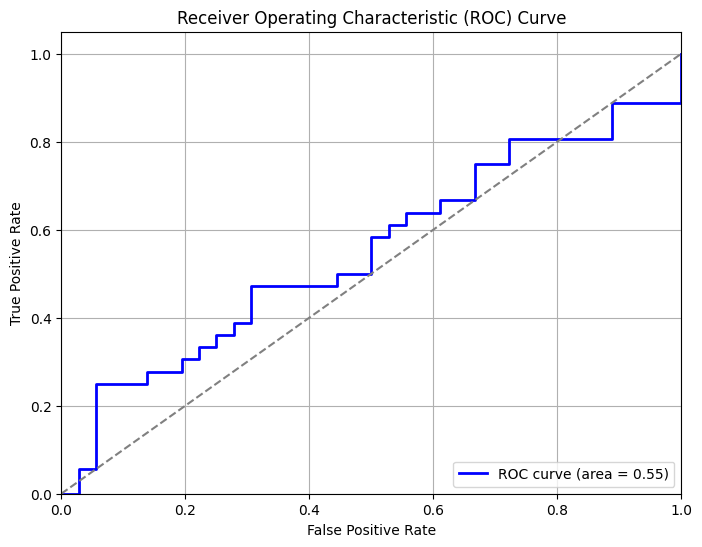

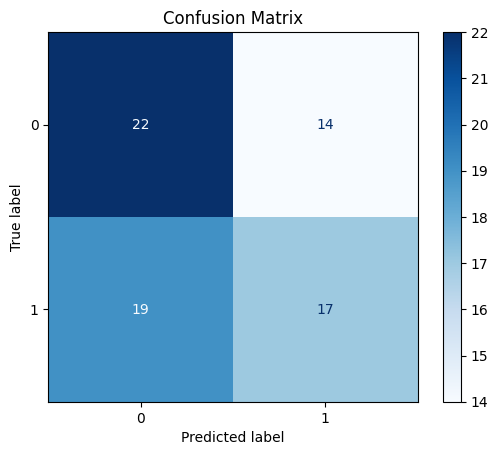

Test Accuracy: 0.5417
Training Accuracy: 0.9444


In [229]:
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Confusion matrix
y_pred = log_reg.predict(reg_X_test)
cm = confusion_matrix(reg_y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Accuracy
accuracy = accuracy_score(reg_y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Training accuracy
train_accuracy = accuracy_score(reg_y_train, log_reg.predict(reg_X_train))
print(f'Training Accuracy: {train_accuracy:.4f}')

##### Strategy II: Predict price (using Sinusoidal Regression) then use price to classify

In [232]:
### Define the model
def sinusoidal_model(X, A, B, C, D):
    '''
    Description
    --------------------------------------------------
    Constructs a sinusoidal model as a weighted sum of
    sine terms based on the given parameters.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix where 
      each column represents a feature
    + A : list or numpy.ndarray; the amplitudes for 
      each feature's sine term
    + B : list or numpy.ndarray; the frequencies for 
      each feature's sine term
    + C : list or numpy.ndarray; the phase shifts for 
      each feature's sine term
    + D : float; the constant term to be added to the 
      sum of sine terms
    
    Outputs
    --------------------------------------------------
    + Returns the computed sinusoidal function as a 
      numpy array.
    '''
    num_features = X.shape[1] # i.e. num. cols.
    
    ### Initialize the sinusoidal function
    sinusoidal_term = 0
    
    ### Construct the sinusoidal function as a weighted sum of sine terms
    for i in range(num_features):
        sinusoidal_term += A[i] * np.sin(B[i] * X[:, i] + C[i])
    
    ### Add the constant term D
    return sinusoidal_term + D

In [234]:
### Define the objective function for hyperopt
def objective(X, y, params):
    '''
    Description
    --------------------------------------------------
    Defines the objective function for hyperopt to 
    minimize. This function computes the mean squared 
    error between the actual target values and the 
    predicted values from the sinusoidal model.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix where 
      each column represents a feature
    + y : numpy.ndarray; the actual target values
    + params : dict; a dictionary containing the 
      parameters for the sinusoidal model, with keys 
      'A_i', 'B_i', 'C_i' for each feature i, and 'D' 
      for the constant term
    
    Outputs
    --------------------------------------------------
    + Returns the mean squared error (MSE) between 
      the actual target values and the predicted 
      values from the sinusoidal model.
    '''
    num_features = X.shape[1]
    A = [params[f'A_{i}'] for i in range(num_features)]
    B = [params[f'B_{i}'] for i in range(num_features)]
    C = [params[f'C_{i}'] for i in range(num_features)]
    D = params['D']
    
    y_pred = sinusoidal_model(X, A, B, C, D)
    loss = mean_squared_error(y, y_pred)
    return loss

In [236]:
def get_res_df(reg_df, y_preds, idx):
    '''
    Description
    --------------------------------------------------
    Constructs a result DataFrame that includes 
    predictions for the next month's values, current 
    month's values (adjusted), percentage change 
    predictions, and buy signals.
    
    Inputs
    --------------------------------------------------
    + reg_df : pandas.DataFrame; the original 
      regression DataFrame containing historical data
    + y_preds : numpy.ndarray; the predicted values 
      for the next month
    + idx : pandas.Index; the index for the resulting 
      DataFrame
    
    Outputs
    --------------------------------------------------
    + Returns a pandas DataFrame with predictions and 
      calculated fields.
    '''
    res_df = pd.DataFrame(index = idx)
    res_df[f'{cotton_col}_next_month_pred'] = y_preds

    ### Deals with values outside of validation range
    curr_val = [res_df[f'{cotton_col}_next_month_pred'][i] if i in res_df[f'{cotton_col}_next_month_pred'].index else reg_df[cotton_col][i + 1] for i in res_df[f'{cotton_col}_next_month_pred'].index - 1]
    res_df[f'{cotton_col}_curr_month_pred'] = curr_val

    res_df['next_month_pct_change_pred'] = res_df.apply(lambda row : 100 * (row[[f'{cotton_col}_next_month_pred']] - row[f'{cotton_col}_curr_month_pred']) / row[f'{cotton_col}_curr_month_pred'], axis = 1)
    res_df['buy_true'] = reg_df.iloc[train_boundary :, list(reg_df.columns).index('buy')].values
    res_df['buy_pred'] = (res_df['next_month_pct_change_pred'] > 0).astype(int)
    
    return res_df

In [2157]:
### Set up hyperopt
X = reg_X_train.values
y = reg_y_num_train.values
num_features = X.shape[1]
space = {
    **{f'A_{i}': hp.uniform(f'A_{i}', 0, 2) for i in range(num_features)},
    **{f'B_{i}': hp.uniform(f'B_{i}', 0, 2) for i in range(num_features)},
    **{f'C_{i}': hp.uniform(f'C_{i}', 0, 2 * np.pi) for i in range(num_features)},
    'D': hp.uniform('D', -1, 1)
}

trials = Trials()
best = fmin(fn=lambda params: objective(X, y, params),
            space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████████████████████████████████████████| 100/100 [10:40<00:00,  6.40s/trial, best loss: 1168.1380787013168]


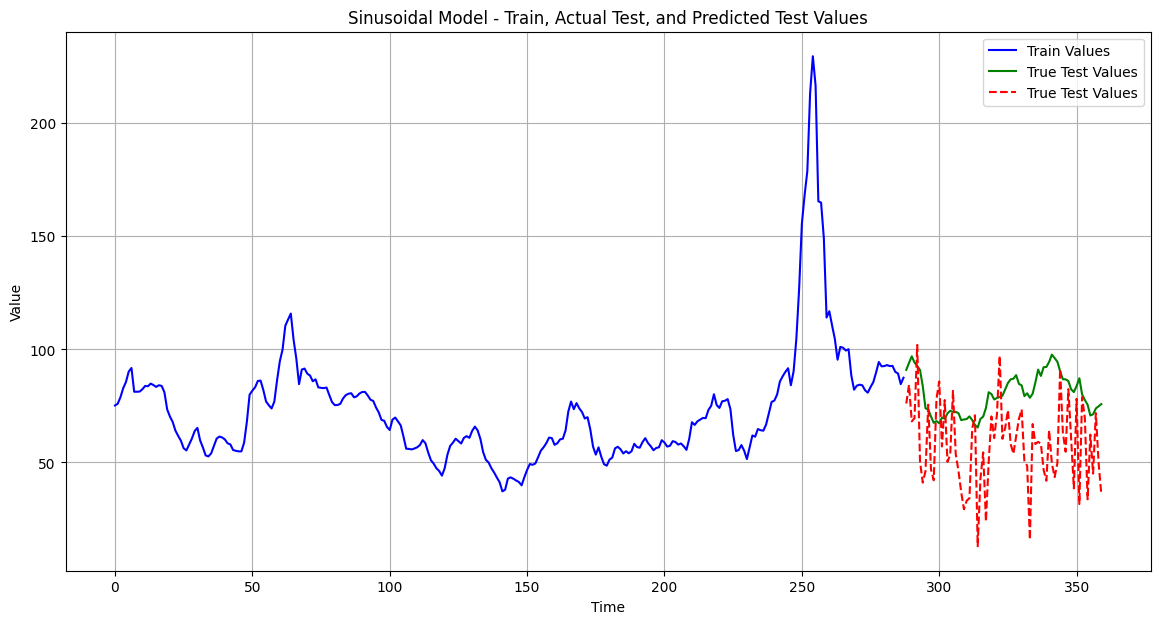

In [2158]:
### Evaluate the results
best_A = [best[f'A_{i}'] for i in range(num_features)]
best_B = [best[f'B_{i}'] for i in range(num_features)]
best_C = [best[f'C_{i}'] for i in range(num_features)]
best_D = best['D']

y_pred_sin = sinusoidal_model(reg_X_test.values, best_A, best_B, best_C, best_D)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_sin, label='True Test Values', color='red', ls = '--')

plt.title('Sinusoidal Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [2159]:
train_idx = range(train_boundary)
test_idx = range(train_boundary, len(reg_df))

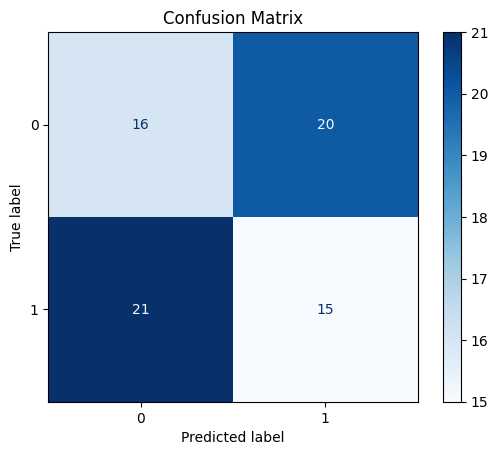

Test Accuracy: 0.4306


In [2160]:
res_df = get_res_df(reg_df, y_pred_sin, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Time Series

In [238]:
y_ts = reg_df[f'{cotton_col}_next_month']
y_ts_train, y_ts_test = y_ts.iloc[: train_boundary], y_ts.iloc[train_boundary :]

In [240]:
m = 12
SARIMAXmodel = SARIMAX(y_ts_train, order = (4, 2, 3), seasonal_order=(2,2,2,m))
SARIMAXmodel = SARIMAXmodel.fit(disp=0)

In [241]:
y_pred_ts = SARIMAXmodel.predict(start = y_ts_test.index[0], end = y_ts_test.index[-1])

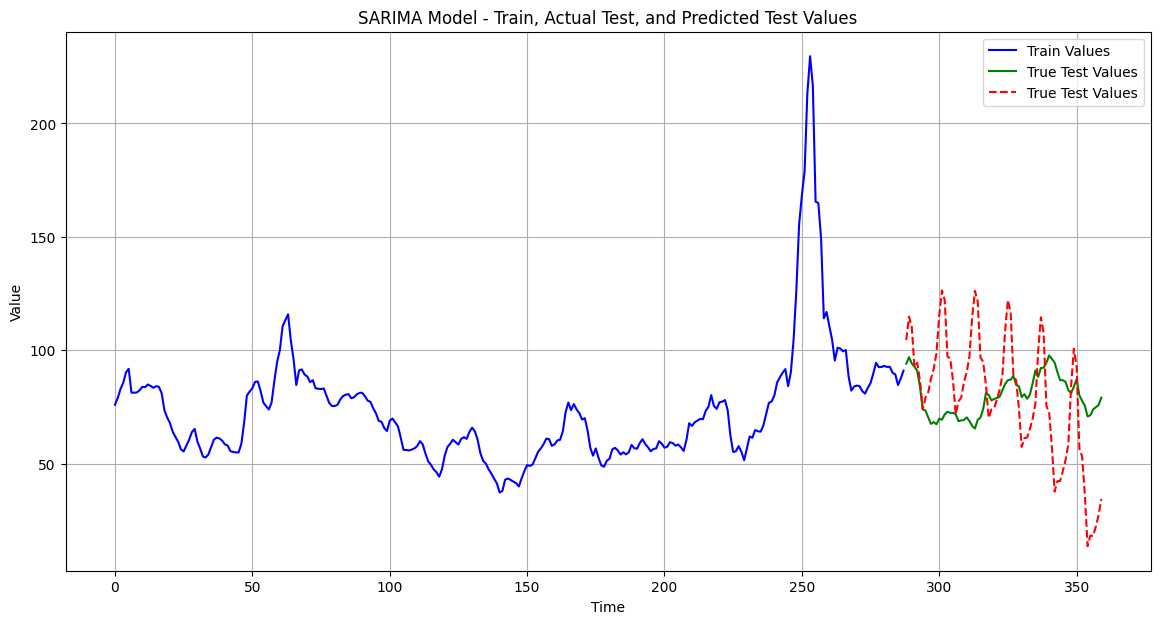

In [242]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_ts_train)), y_ts_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_ts_train), len(y_ts_train) + len(y_ts_test)), y_ts_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_ts_train), len(y_ts_train) + len(y_ts_test)), y_pred_ts, label='True Test Values', color='red', ls = '--')

plt.title('SARIMA Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

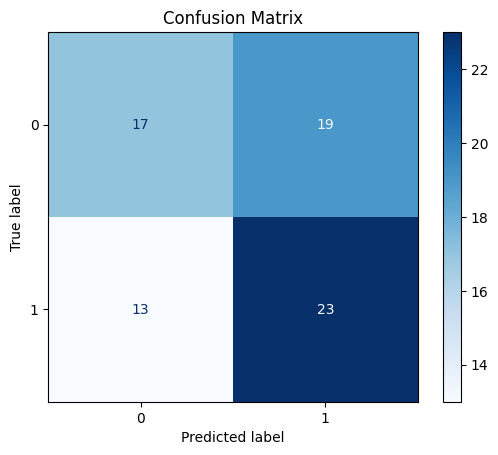

Test Accuracy: 0.5556


In [243]:
res_df = get_res_df(reg_df, y_pred_ts, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Neural Network

##### Strategy I: Direct Classification (Neural Network)

###### Initial Model

In [2170]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [2385]:
# num_epochs = 20
# batch_size = 32

# model = Sequential([
#     Dense(16, input_dim=X.shape[1], activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(32, activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation ==> binary classification
# ])

# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

# history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

# train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

# print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

### This is the best model I have gotten so far
model_path = './models/nn_buy_cotton_classification_model_1_062224.pkl'

# Load the model
with open(model_path, 'rb') as f:
    model = pickle.load(f)
    
num_epochs = 4
batch_size = 32
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Train Accuracy: 0.7158, Train Loss: 0.5674
Test Accuracy: 0.6806, Test Loss: 0.6640


3/3 [==============================] - 0s 3ms/step


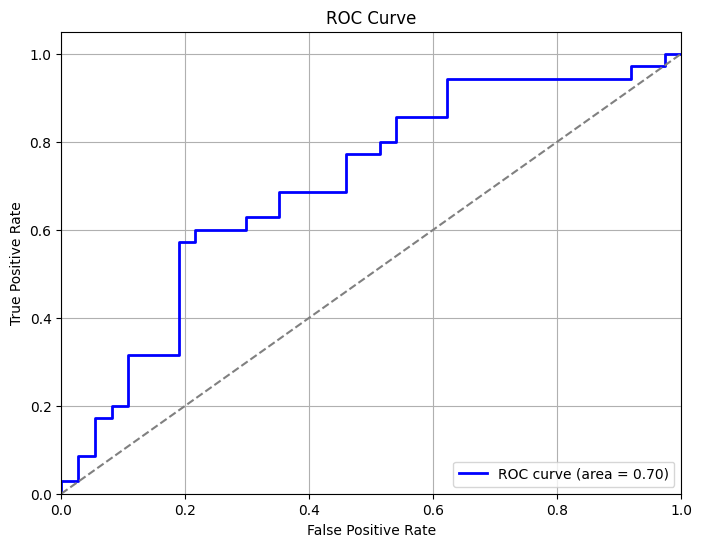

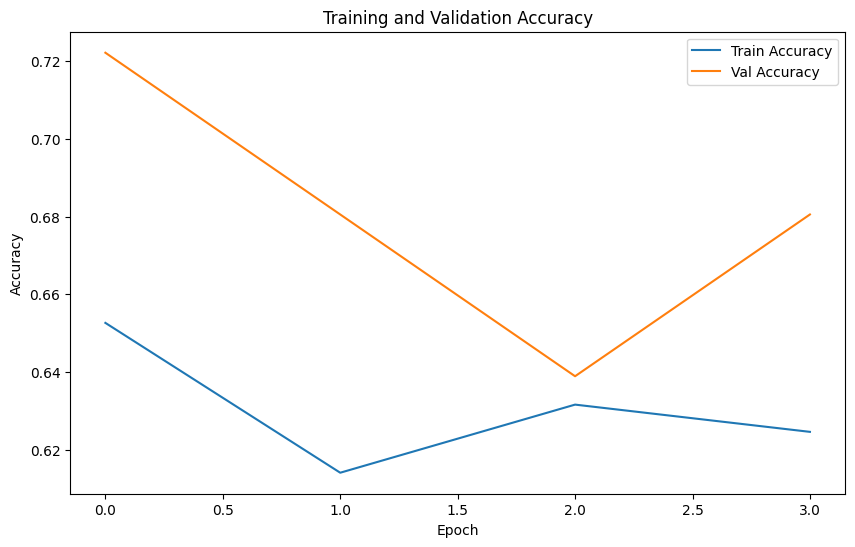

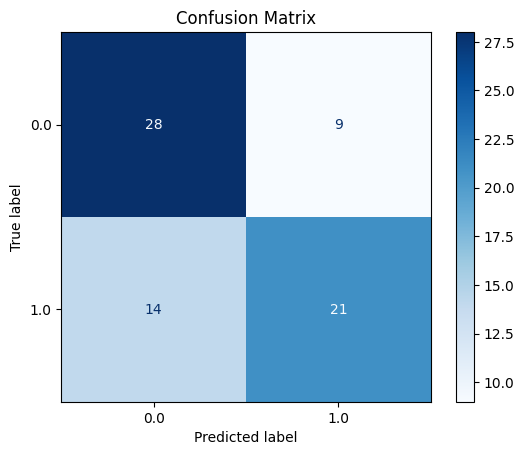

In [2387]:
### Predictions
threshold = 0.5
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

###### Hyperparmeter-Tuned Model 

Since `RandomizedSearchCV` & `GridSearchCV` were giving me issues, I manually finetuned the hyperparameters.

In [15]:
### Function to create a Keras classification model
def create_nn_class_model(epochs, batch_size, learning_rate = 0.001, dropout_rate = 0.5, num_layers = 2, num_nodes = 16):
    '''
    Description
    --------------------------------------------------
    Creates and compiles a Keras neural network model 
    for binary classification.
    
    Inputs
    --------------------------------------------------
    + epochs : int; the number of epochs for training
    + batch_size : int; the batch size for training
    + learning_rate : float, default=0.001; the 
      learning rate for the Adam optimizer
    + dropout_rate : float, default=0.5; the dropout 
      rate for regularization
    + num_layers : int, default=2; the number of 
      hidden layers in the model
    + num_nodes : int, default=16; the number of nodes 
      in each hidden layer
    
    Outputs
    --------------------------------------------------
    + Returns the compiled Keras model.
    '''
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Function to create a Keras regression model
def create_nn_reg_model(epochs, batch_size, learning_rate = 0.001, dropout_rate = 0.5, num_layers = 2, num_nodes = 16):
    '''
    Description
    --------------------------------------------------
    Creates and compiles a Keras neural network model 
    for regression.
    
    Inputs
    --------------------------------------------------
    + epochs : int; the number of epochs for training
    + batch_size : int; the batch size for training
    + learning_rate : float, default=0.001; the 
      learning rate for the Adam optimizer
    + dropout_rate : float, default=0.5; the dropout 
      rate for regularization
    + num_layers : int, default=2; the number of 
      hidden layers in the model
    + num_nodes : int, default=16; the number of nodes 
      in each hidden layer
    
    Outputs
    --------------------------------------------------
    + Returns the compiled Keras model.
    '''
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

### Function to sample random hyperparameters
def sample_hyperparameters(param_dist):
    '''
    Description
    --------------------------------------------------
    Samples random hyperparameters from the given 
    parameter distributions.
    
    Inputs
    --------------------------------------------------
    + param_dist : dict; a dictionary containing the 
      distributions for each hyperparameter
    
    Outputs
    --------------------------------------------------
    + Returns a dictionary of sampled hyperparameters.
    '''
    params = {}
    for key, dist in param_dist.items():
        if hasattr(dist, 'rvs'):
            params[key] = dist.rvs()
        else:
            params[key] = np.random.choice(dist)
    return params

### Function to perform Randomized Search CV
def RandomCV(X, y, param_dist, reg = False, n_iter = 20, cv = 4, random_state = 29, verbose = 0):
    '''
    Description
    --------------------------------------------------
    Performs Randomized Search Cross-Validation to 
    find the best hyperparameters for a Keras model.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix
    + y : numpy.ndarray; the target values
    + param_dist : dict; a dictionary containing the 
      distributions for each hyperparameter
    + reg : bool, default=False; flag indicating 
      whether the task is regression (True) or 
      classification (False)
    + n_iter : int, default=20; the number of 
      iterations for the random search
    + cv : int, default=4; the number of folds for 
      cross-validation
    + random_state : int, default=29; the random seed 
      for reproducibility
    + verbose : int, default=0; the verbosity level 
      for printing progress
    
    Outputs
    --------------------------------------------------
    + Returns the best model and the best parameters 
      found during the search.
    '''
    np.random.seed(random_state)
    tf.random.set_seed(random_state)
    
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for i in range(n_iter):
        # Sample random hyperparameters
        params = sample_hyperparameters(param_dist)
        
        ### Iterations Displayed Every 10
        if verbose == 0:
            if i % 10 == 0:
                print(f"Iteration {i+1}/{n_iter}")
        
        ### Displayed every time
        else:   
            print(f"Iteration {i+1}/{n_iter}")
            print(f"Sampled parameters: {params}")
        
        # Cross-validation
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        cv_scores = []
        
        for train_index, val_index in kf.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]
            
            if reg:
                model = create_nn_reg_model(**params)
                model.fit(X_train_cv, y_train_cv, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
                y_pred = model.predict(X_val_cv)
                
                ### We want to get the highest accuracy
                ### mse is not as important
                res_df = get_res_df(reg_df, y_pred, idx = val_index)
                accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
                cv_scores.append(accuracy)
            else:
                model = create_nn_class_model(**params)
                model.fit(X_train_cv, y_train_cv, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
                val_loss, val_acc = model.evaluate(X_val_cv, y_val_cv, verbose=0)
                cv_scores.append(val_acc)
        
        mean_cv_score = np.mean(cv_scores)
        print(f"Mean CV score: {mean_cv_score:.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params
            best_model = model
    
    print(f"Best CV score: {best_score:.4f} with parameters: {best_params}")
    return best_model, best_params

In [2176]:
n_iter = 100
X = X_train.values
y = y_train.values
param_dist = {
    'learning_rate': uniform(0.001, 0.1),  
    'dropout_rate': uniform(0, 0.7),     
    'num_layers': [1, 2, 3],               
    'num_nodes': [16, 32, 64],             
    'epochs': [10, 20, 30, 40],                
    'batch_size': [16, 32, 64]             
}
best_model, best_params = RandomCV(X, y, param_dist, reg = False, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
Mean CV score: 0.4583
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.4826
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
Mean CV score: 0.6042
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.4896
Iteration 5/100
Sampled parameters: {'learning_rate': 0.0850919735388559, 'dropout_rate': 0.5664073940705749, 'num_layers': 3, 'num_nodes': 64, 'epochs': 20, 'batch_size': 64}
Mean CV score: 0.4549
Ite

Train Accuracy: 0.9792, Train Loss: 0.0467
Test Accuracy: 0.6111, Test Loss: 13.3104
3/3 [==============================] - 0s 4ms/step


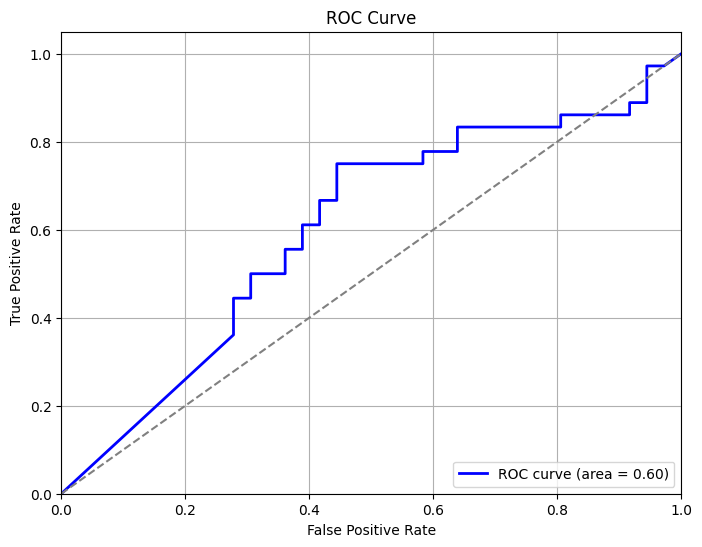

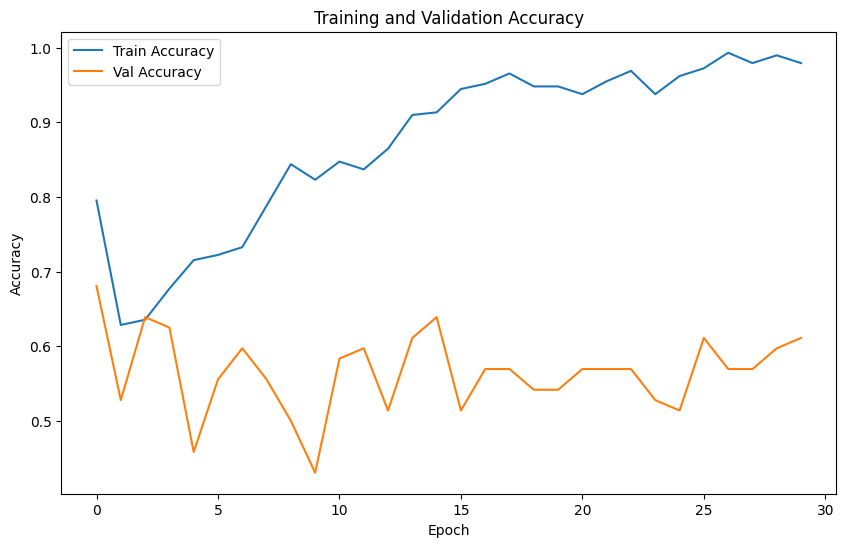

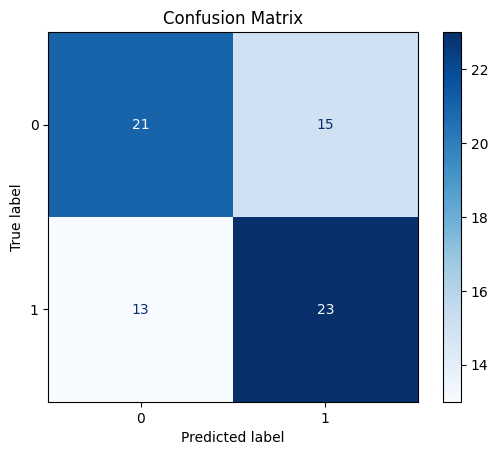

In [2177]:
#### Performance Evaluation
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

threshold = 0.5
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

##### Strategy II: Predict price (using Neural Network) then use price to classify

###### Initial Model

In [2180]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [2181]:
num_epochs = 20
batch_size = 32

model = Sequential([
    Dense(16, input_dim=X.shape[1], activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(16, activation='relu'),
    Dense(1)  # No activation ==> Regression
])

model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

model.summary()

history = model.fit(X_train, y_num_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

y_pred_nn = model.predict(X_test)
mse = mean_squared_error(y_num_test, y_pred_nn)

print(f"Mean Squared Error on Test Set: {mse}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                13792     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14881 (58.13 KB)
Trainable params: 14881 (

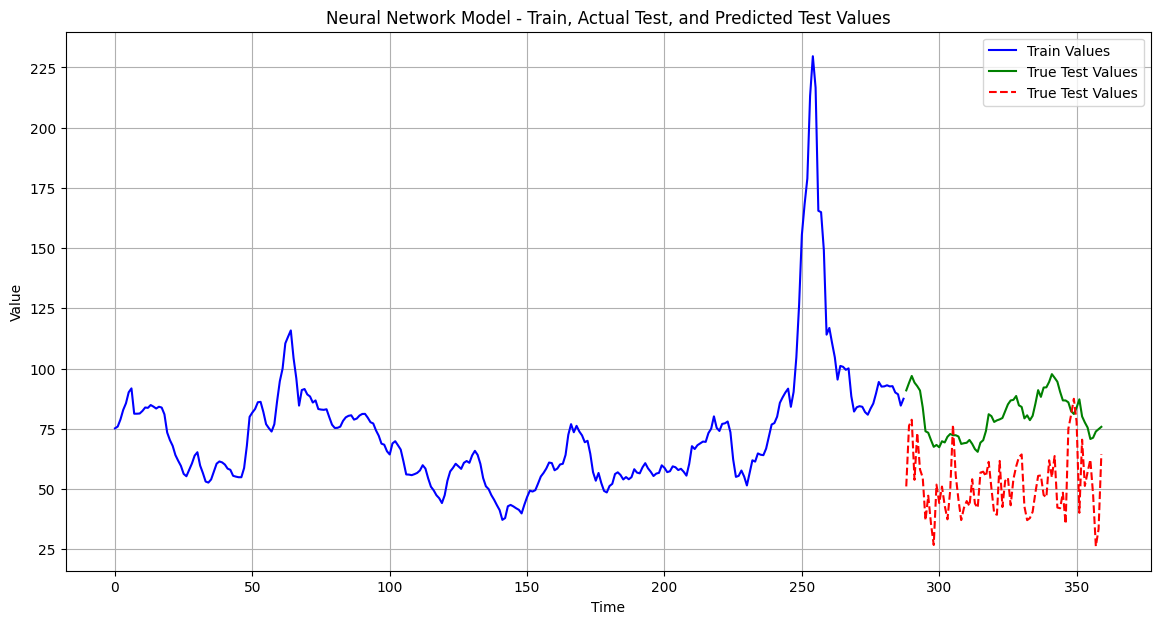

In [2182]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_nn, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

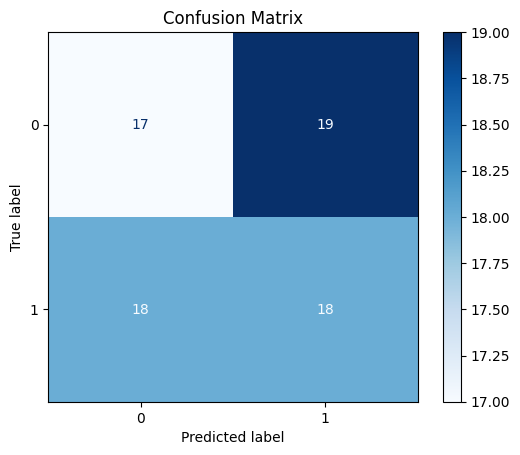

Test Accuracy: 0.4861


In [2183]:
res_df = get_res_df(reg_df, y_pred_nn.flatten(), idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparmeter-Tuned Model

In [2185]:
X = X_train.values
y = y_num_train.values
best_model, best_params = RandomCV(X, y, param_dist, reg = True, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
3/3 [==============================] - 0s 4ms/step
Mean CV score: 0.5139
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5000
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
3/3 [==============================] - 0s 4ms/step
Mean CV score: 0.5556
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 2ms/step
Mean CV score: 0.52

In [2186]:
history = best_model.fit(reg_X_train, reg_y_num_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_best_model = best_model.predict(reg_X_test)
mse_best_model = mean_squared_error(reg_y_num_test, y_pred_best_model)

print(f"Mean Squared Error on Test Set: {mse}")

3/3 [==============================] - 0s 3ms/step
Mean Squared Error on Test Set: 953.3447525160931


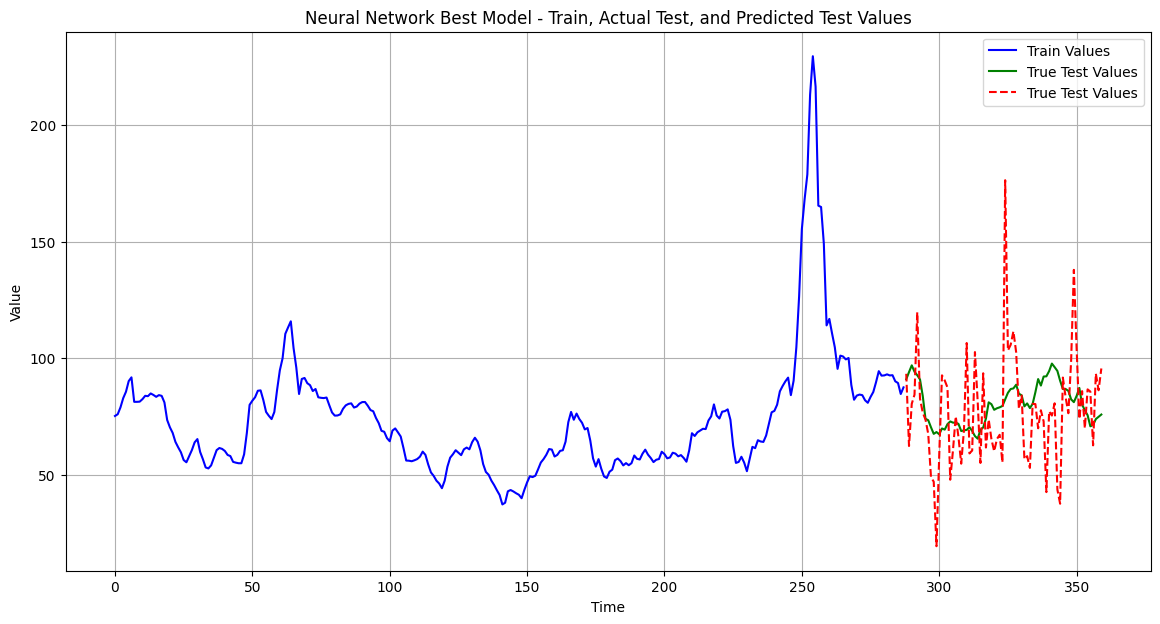

In [2187]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_best_model, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Best Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

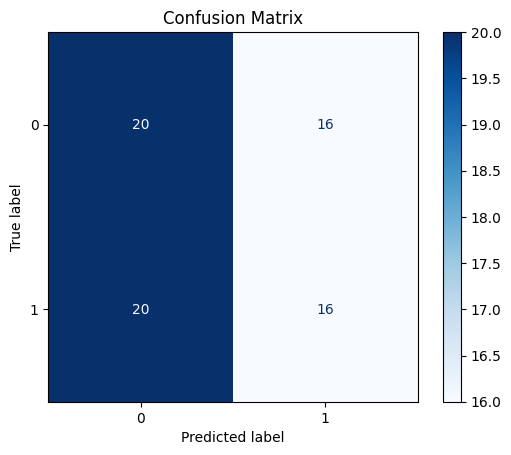

Test Accuracy: 0.5000


In [2188]:
res_df = get_res_df(reg_df, y_pred_best_model, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Random Forrest

##### Strategy I: Direct Classification (Random Forrest)

###### Initial Model

In [249]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state = 29)

# Train the model
rf_classifier.fit(reg_X_train, reg_y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(reg_X_test)

# Evaluate the model
accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.5972222222222222
Confusion Matrix:



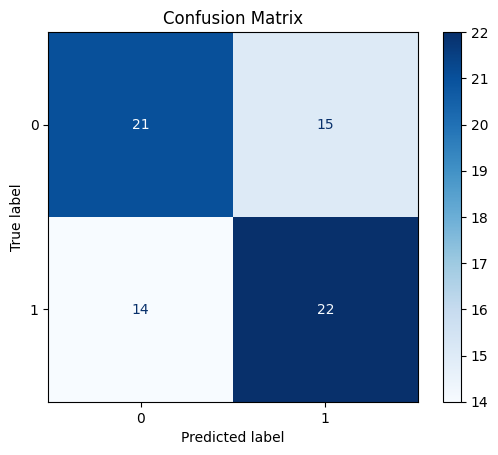

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59        36
           1       0.59      0.61      0.60        36

    accuracy                           0.60        72
   macro avg       0.60      0.60      0.60        72
weighted avg       0.60      0.60      0.60        72



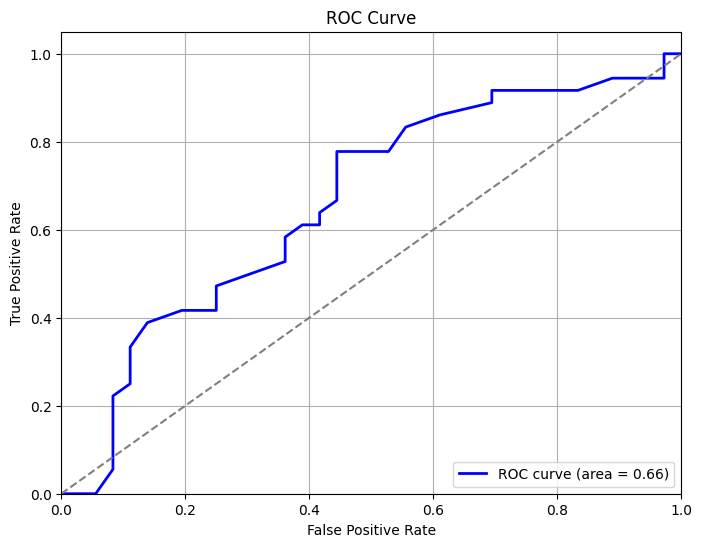

In [250]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = rf_classifier.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

###### Hyperparamter-Tuned Model

In [2195]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, 4),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}


# Create the Random Forest Classifier
rf_class = RandomForestClassifier(random_state = 29)

# Perform Randomized Search Cross-Validation
random_search_rf_class = RandomizedSearchCV(rf_class, param_distributions = param_dist, n_iter = 100, cv = 10, verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_class.fit(reg_X_train, reg_y_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_class.best_params_)
best_rf_class = random_search_rf_class.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 184}


In [2440]:
y_pred_rf = best_rf_class.predict(reg_X_test)

accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.6805555555555556
Confusion Matrix:



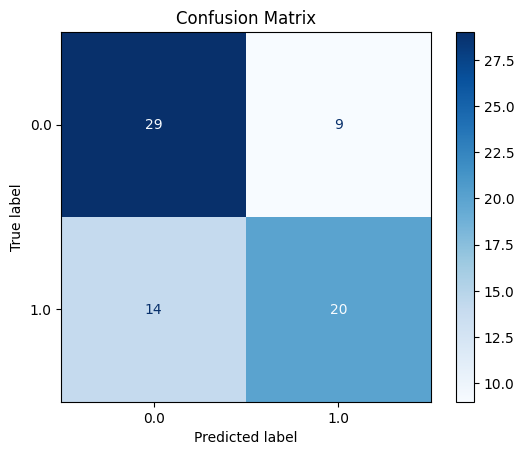

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.76      0.72        38
         1.0       0.69      0.59      0.63        34

    accuracy                           0.68        72
   macro avg       0.68      0.68      0.68        72
weighted avg       0.68      0.68      0.68        72



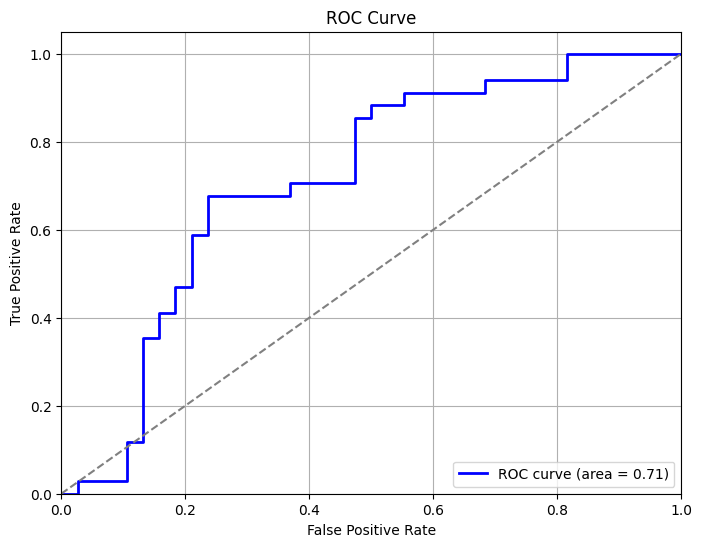

In [2442]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = best_rf_class.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

In [2444]:
# ## Uncomment when a new model is to be added
# ## MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_1_062424.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf_class, file)

##### Strategy II: Predict price (using Random Forrest) then use price to classify

###### Initial Model

In [2201]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

rf_regressor.fit(reg_X_train, reg_y_num_train)

y_pred_rf = rf_regressor.predict(reg_X_test)

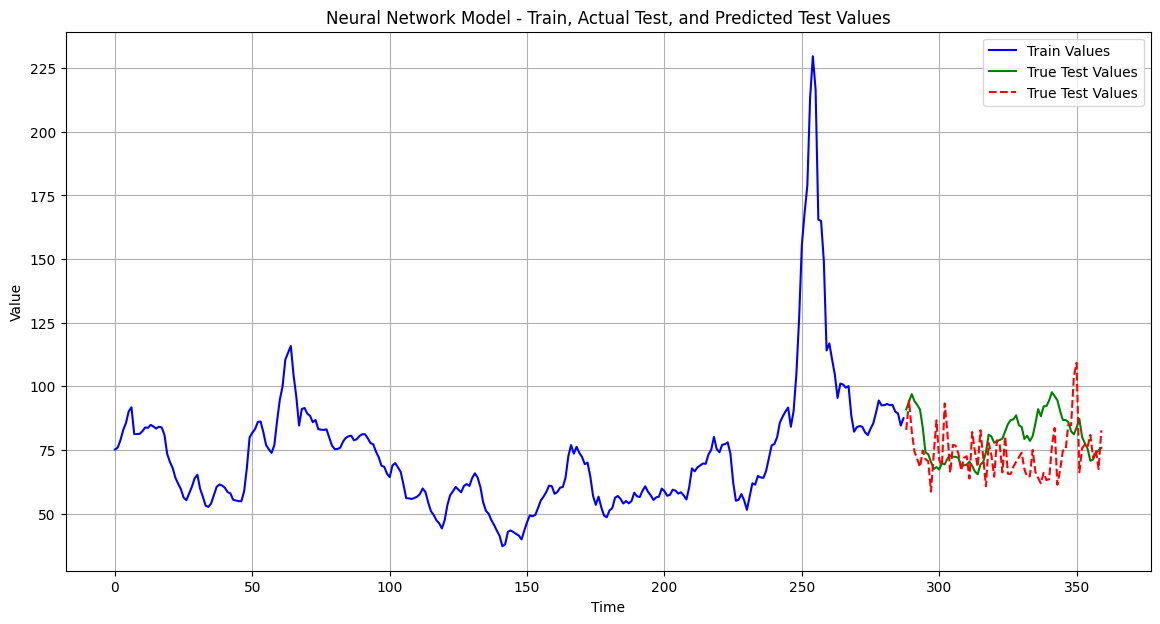

In [2202]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# accuracy = accuracy_score(reg_y_test, y_pred_rf)
# cm = confusion_matrix(reg_y_test, y_pred_rf)
# class_report = classification_report(reg_y_test, y_pred_rf)

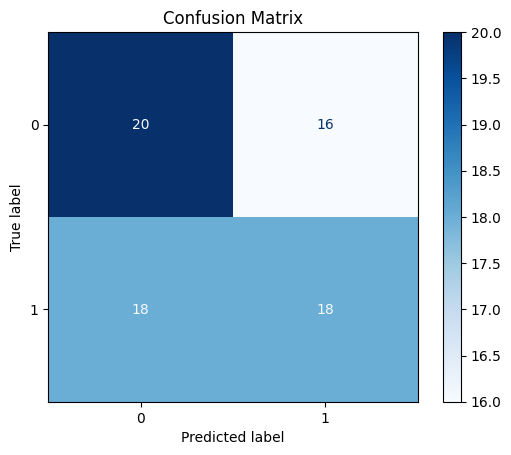

Test Accuracy: 0.5278


In [2203]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparamter-Tuned Model

In [1910]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, X.shape[1]),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

random_search_rf_reg = RandomizedSearchCV(rf_regressor, param_distributions = param_dist, n_iter = n_iter, cv = 4,
                                   verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_reg.fit(reg_X_train, reg_y_num_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_reg.best_params_)
best_rf_reg = random_search_rf_reg.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 12, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 479}


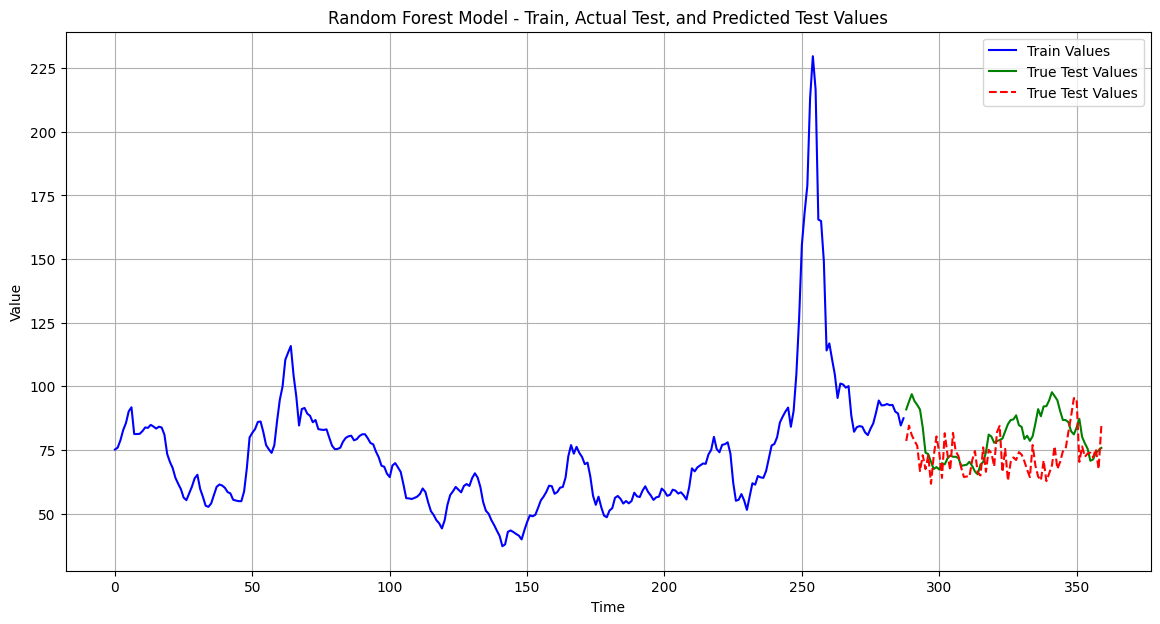

In [2255]:
y_pred_rf = best_rf_reg.predict(reg_X_test)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Random Forest Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

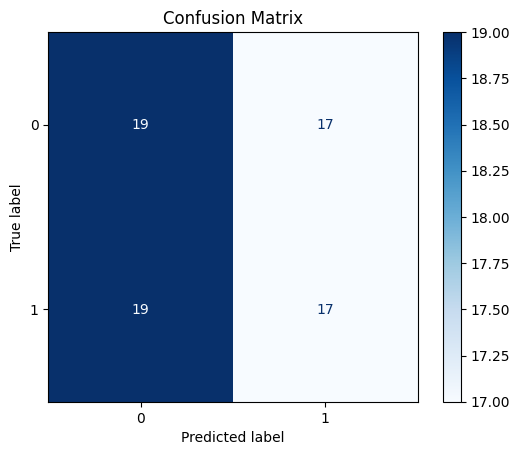

Test Accuracy: 0.5000


In [1912]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
### Uncomment when a new model is to be added
### MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_1_062324.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf, file)

## Spike Exclusive

#### Basic Regression

##### Strategy I: Direct Classification (Logistic Regression)

In [2257]:
remove_outliers = False
remove_spike = True

if remove_outliers:
    train_boundary = int((1 - test_size) * len(df_no_outliers))
    reg_df = df_no_outliers
    reg_X_train = X_train_no_outliers
    reg_y_train = y_train_no_outliers
    reg_y_num_train = y_num_train_no_outliers
    
    reg_X_test = X_test_no_outliers
    reg_y_test = y_test_no_outliers
    reg_y_num_test = y_num_test_no_outliers
else:
    train_boundary = int((1 - test_size) * len(df))
    reg_df = df
    reg_X_train = X_train
    reg_y_train = y_train
    reg_y_num_train = y_num_train
    
    reg_X_test = X_test
    reg_y_test = y_test
    reg_y_num_test = y_num_test
    
if remove_spike:
    train_boundary = int((1 - test_size) * len(df_no_spike))
    reg_df = df_no_spike
    reg_X_train = X_train_no_spike
    reg_y_train = y_train_no_spike
    reg_y_num_train = y_num_train_no_spike
    
    reg_X_test = X_test_no_spike
    reg_y_test = y_test_no_spike
    reg_y_num_test = y_num_test_no_spike
    

log_reg = LogisticRegression(random_state = 29)

log_reg.fit(reg_X_train, reg_y_train)

y_pred_proba = log_reg.predict_proba(reg_X_test)[:, 1]

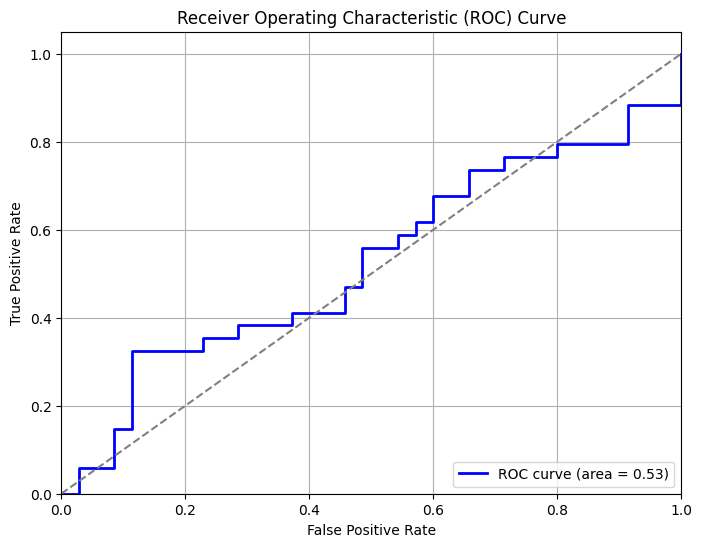

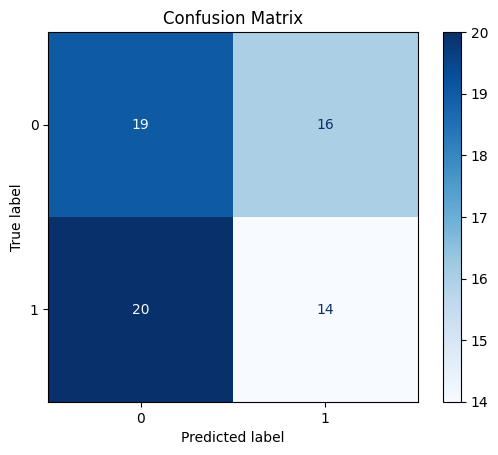

Test Accuracy: 0.4783
Training Accuracy: 0.9487


In [2205]:
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Confusion matrix
y_pred = log_reg.predict(reg_X_test)
cm = confusion_matrix(reg_y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Accuracy
accuracy = accuracy_score(reg_y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Training accuracy
train_accuracy = accuracy_score(reg_y_train, log_reg.predict(reg_X_train))
print(f'Training Accuracy: {train_accuracy:.4f}')

##### Strategy II: Predict price (using Sinusoidal Regression) then use price to classify

In [2206]:
### Set up hyperopt
X = reg_X_train.values
y = reg_y_num_train.values
num_features = X.shape[1]
space = {
    **{f'A_{i}': hp.uniform(f'A_{i}', 0, 2) for i in range(num_features)},
    **{f'B_{i}': hp.uniform(f'B_{i}', 0, 2) for i in range(num_features)},
    **{f'C_{i}': hp.uniform(f'C_{i}', 0, 2 * np.pi) for i in range(num_features)},
    'D': hp.uniform('D', -1, 1)
}

trials = Trials()
best = fmin(fn=lambda params: objective(X, y, params),
            space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|███████████████████████████████████████████████| 100/100 [11:23<00:00,  6.83s/trial, best loss: 603.3797219797156]


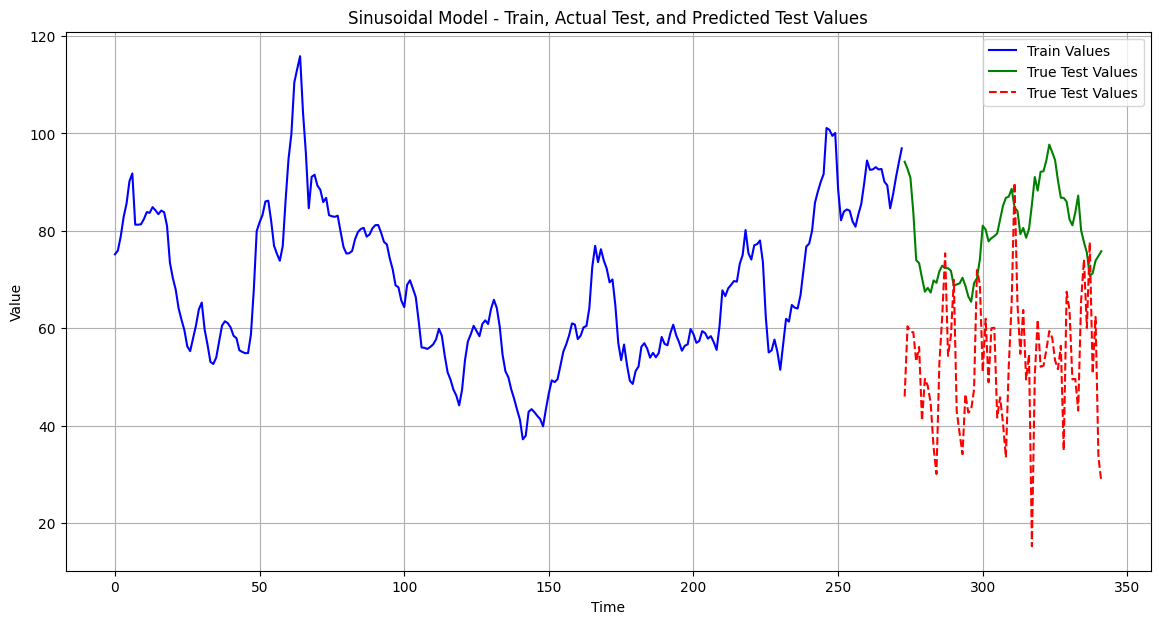

In [2207]:
### Evaluate the results
best_A = [best[f'A_{i}'] for i in range(num_features)]
best_B = [best[f'B_{i}'] for i in range(num_features)]
best_C = [best[f'C_{i}'] for i in range(num_features)]
best_D = best['D']

y_pred_sin = sinusoidal_model(reg_X_test.values, best_A, best_B, best_C, best_D)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_sin, label='True Test Values', color='red', ls = '--')

plt.title('Sinusoidal Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [2208]:
train_idx = range(train_boundary)
test_idx = range(train_boundary, len(reg_df))

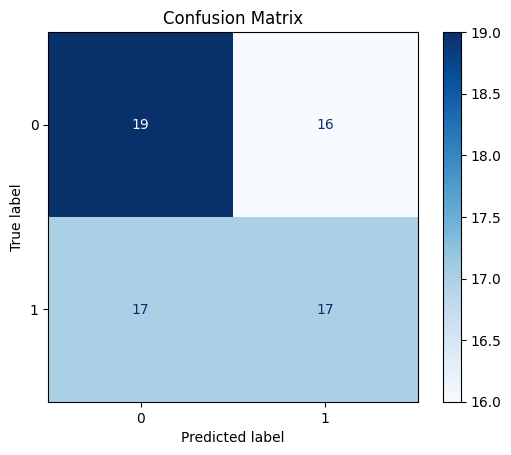

Test Accuracy: 0.5217


In [2209]:
res_df = get_res_df(reg_df, y_pred_sin, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Time Series (Not Possible with the Spike Exclusive Data

#### Neural Network

##### Strategy I: Direct Classification (Neural Network)

###### Initial Model

In [1743]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [2434]:
# num_epochs = 20
# batch_size = 32

# model = Sequential([
#     Dense(16, input_dim=X.shape[1], activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(32, activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation ==> binary classification
# ])

# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

# history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

# train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

# print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

### This is the best model I have gotten so far
model_path = './models/nn_buy_cotton_classification_model_1_062224_full_data_offset1.pkl'

# Load the model
with open(model_path, 'rb') as f:
    model = pickle.load(f)
    
num_epochs = 4
batch_size = 32
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Train Accuracy: 0.7289, Train Loss: 0.5693
Test Accuracy: 0.6528, Test Loss: 0.6448


3/3 [==============================] - 0s 4ms/step


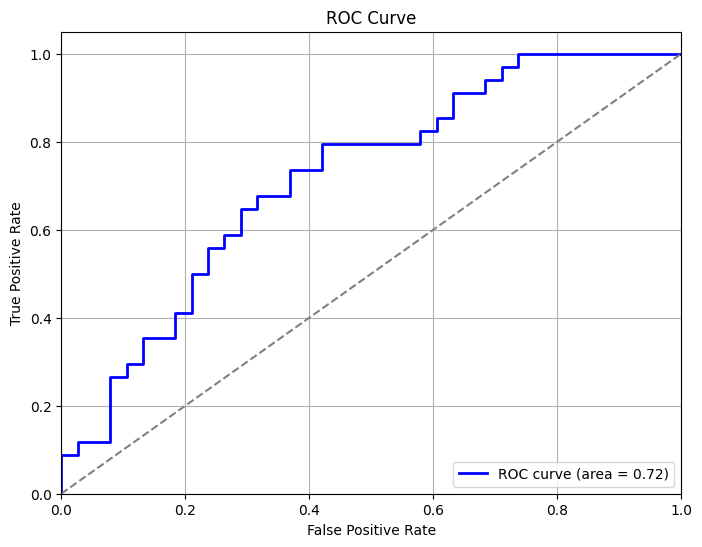

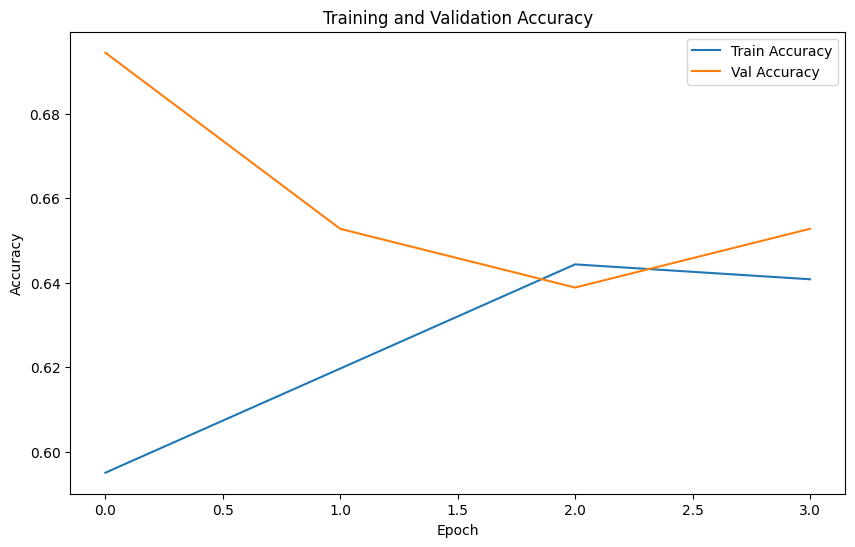

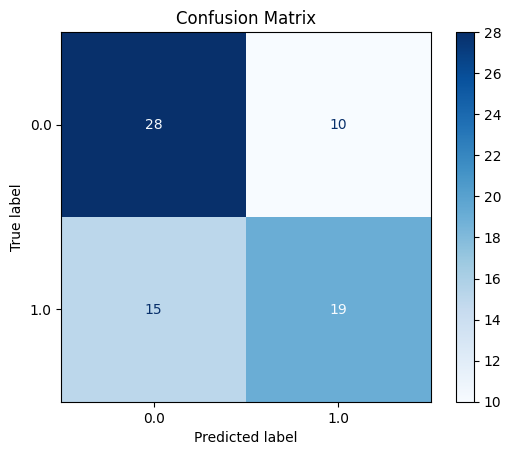

In [2435]:
### Predictions
threshold = 0.5
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

###### Hyperparmeter-Tuned Model 

Since `RandomizedSearchCV` & `GridSearchCV` were giving me issues, I manually finetuned the hyperparameters.

In [1760]:
n_iter = 100
X = X_train.values
y = y_train.values
param_dist = {
    'learning_rate': uniform(0.001, 0.1),  
    'dropout_rate': uniform(0, 0.7),     
    'num_layers': [1, 2, 3],               
    'num_nodes': [16, 32, 64],             
    'epochs': [10, 20, 30, 40],                
    'batch_size': [16, 32, 64]             
}
best_model, best_params = RandomCV(X, y, param_dist, reg = False, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
Mean CV score: 0.4965
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.4653
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
Mean CV score: 0.5694
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.5312
Iteration 5/100
Sampled parameters: {'learning_rate': 0.0850919735388559, 'dropout_rate': 0.5664073940705749, 'num_layers': 3, 'num_nodes': 64, 'epochs': 20, 'batch_size': 64}
Mean CV score: 0.4549
Ite

Mean CV score: 0.5694
Iteration 17/100
Sampled parameters: {'learning_rate': 0.030573913949806877, 'dropout_rate': 0.39431650529273016, 'num_layers': 2, 'num_nodes': 32, 'epochs': 20, 'batch_size': 16}
Mean CV score: 0.5174
Iteration 18/100
Sampled parameters: {'learning_rate': 0.0014839738263887617, 'dropout_rate': 0.44803217662488526, 'num_layers': 2, 'num_nodes': 16, 'epochs': 40, 'batch_size': 64}
Mean CV score: 0.5521
Iteration 19/100
Sampled parameters: {'learning_rate': 0.02792194580577674, 'dropout_rate': 0.0022402604656822866, 'num_layers': 2, 'num_nodes': 32, 'epochs': 20, 'batch_size': 16}
Mean CV score: 0.5035
Iteration 20/100
Sampled parameters: {'learning_rate': 0.09716406289834652, 'dropout_rate': 0.26716215554065154, 'num_layers': 2, 'num_nodes': 32, 'epochs': 10, 'batch_size': 64}
Mean CV score: 0.5035
Iteration 21/100
Sampled parameters: {'learning_rate': 0.04418390337773647, 'dropout_rate': 0.3266361912916783, 'num_layers': 2, 'num_nodes': 32, 'epochs': 10, 'batch_si

Train Accuracy: 0.9132, Train Loss: 0.1990
Test Accuracy: 0.4722, Test Loss: 2.4384
3/3 [==============================] - 0s 3ms/step


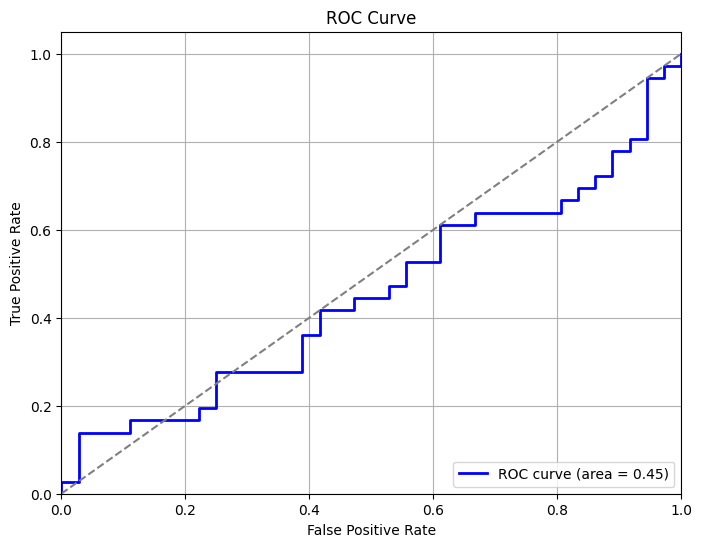

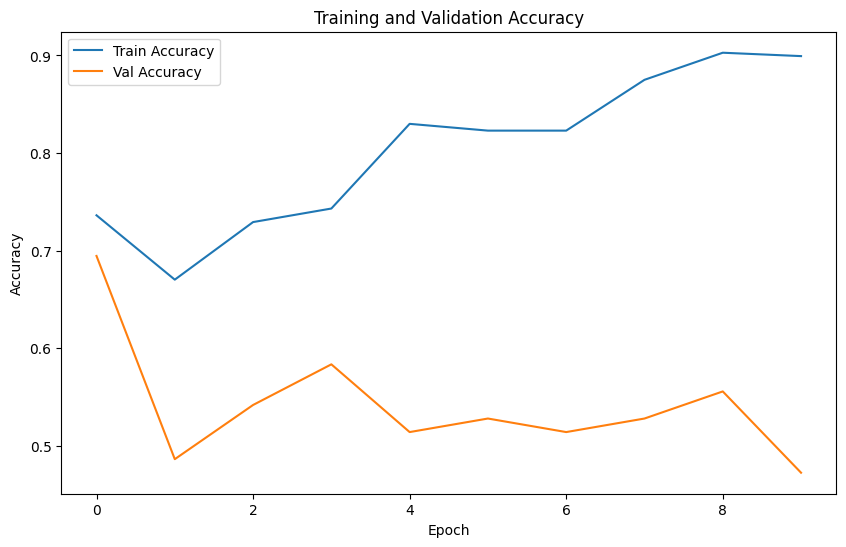

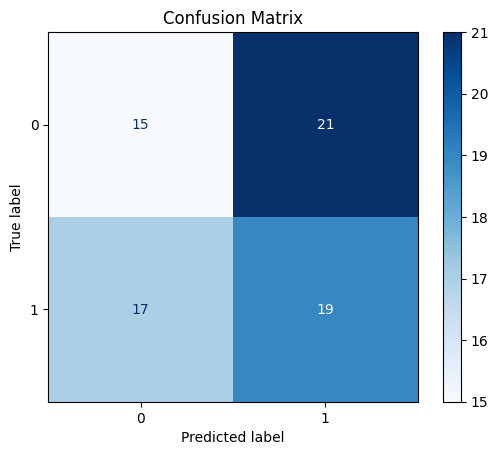

In [1761]:
#### Performance Evaluation
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

threshold = 0.5
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

##### Strategy II: Predict price (using Neural Network) then use price to classify

###### Initial Model

In [1764]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [1765]:
num_epochs = 20
batch_size = 32

model = Sequential([
    Dense(16, input_dim=X.shape[1], activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(16, activation='relu'),
    Dense(1)  # No activation ==> Regression
])

model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

model.summary()

history = model.fit(X_train, y_num_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

y_pred_nn = model.predict(X_test)
mse = mean_squared_error(y_num_test, y_pred_nn)

print(f"Mean Squared Error on Test Set: {mse}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                13792     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14881 (58.13 KB)
Trainable params: 14881 (

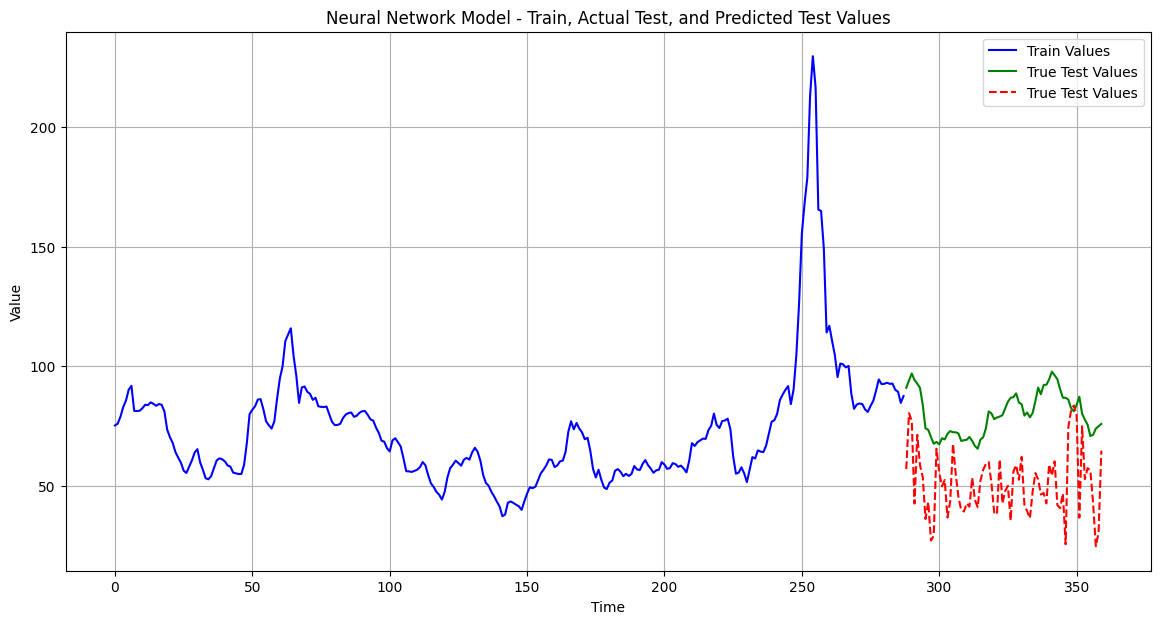

In [1766]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_nn, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

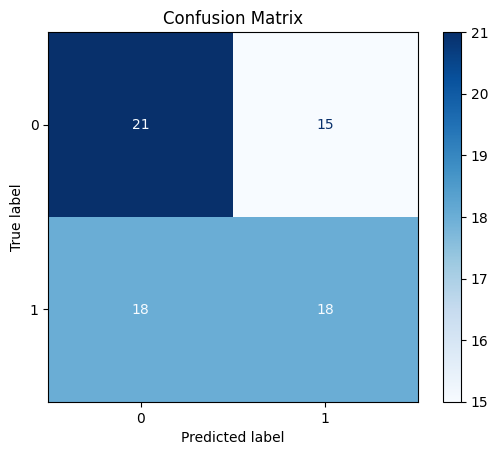

Test Accuracy: 0.5417


In [1767]:
res_df = get_res_df(reg_df, y_pred_nn.flatten(), idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparmeter-Tuned Model

In [1769]:
X = X_train.values
y = y_num_train.values
best_model, best_params = RandomCV(X, y, param_dist, reg = True, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.4931
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 4ms/step
Mean CV score: 0.5278
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
3/3 [==============================] - 0s 2ms/step
Mean CV score: 0.5590
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 2ms/step
Mean CV score: 0.53

3/3 [==============================] - 0s 8ms/step
Mean CV score: 0.5486
Iteration 50/100
Sampled parameters: {'learning_rate': 0.014647137142099819, 'dropout_rate': 0.5299254512931633, 'num_layers': 3, 'num_nodes': 32, 'epochs': 30, 'batch_size': 64}
3/3 [==============================] - 0s 6ms/step
Mean CV score: 0.5069
Iteration 51/100
Sampled parameters: {'learning_rate': 0.0035169186962536784, 'dropout_rate': 0.4306377190290878, 'num_layers': 3, 'num_nodes': 16, 'epochs': 40, 'batch_size': 32}
3/3 [==============================] - 0s 4ms/step
Mean CV score: 0.5312
Iteration 52/100
Sampled parameters: {'learning_rate': 0.029182524235590725, 'dropout_rate': 0.0537694687809755, 'num_layers': 3, 'num_nodes': 16, 'epochs': 20, 'batch_size': 16}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5625
Iteration 53/100
Sampled parameters: {'learning_rate': 0.0070626714570672265, 'dropout_rate': 0.14710640949391351, 'num_layers': 2, 'num_nodes': 64, 'epochs': 20, 'batch_

In [1770]:
history = best_model.fit(reg_X_train, reg_y_num_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_best_model = best_model.predict(reg_X_test)
mse_best_model = mean_squared_error(reg_y_num_test, y_pred_best_model)

print(f"Mean Squared Error on Test Set: {mse}")

3/3 [==============================] - 0s 3ms/step
Mean Squared Error on Test Set: 1046.557090693087


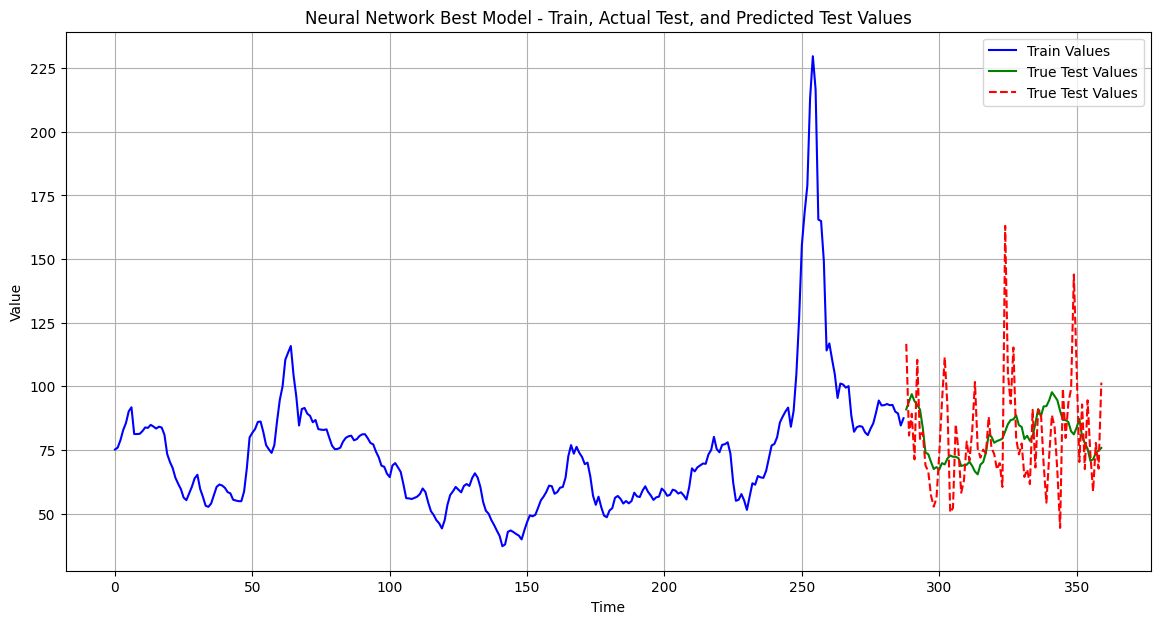

In [1771]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_best_model, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Best Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

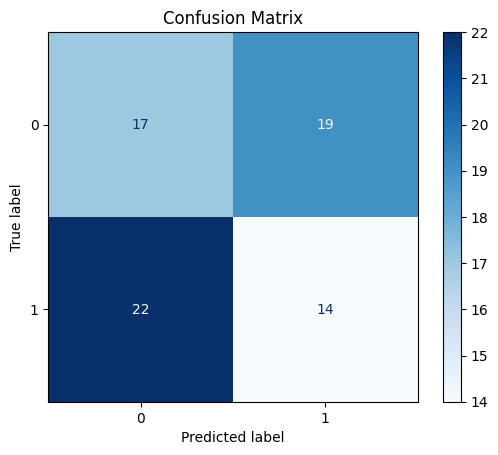

Test Accuracy: 0.4306


In [1772]:
res_df = get_res_df(reg_df, y_pred_best_model, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Random Forrest

##### Strategy I: Direct Classification (Random Forrest)

###### Initial Model

In [2132]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state = 29)

# Train the model
rf_classifier.fit(reg_X_train, reg_y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(reg_X_test)

# Evaluate the model
accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.5942028985507246
Confusion Matrix:



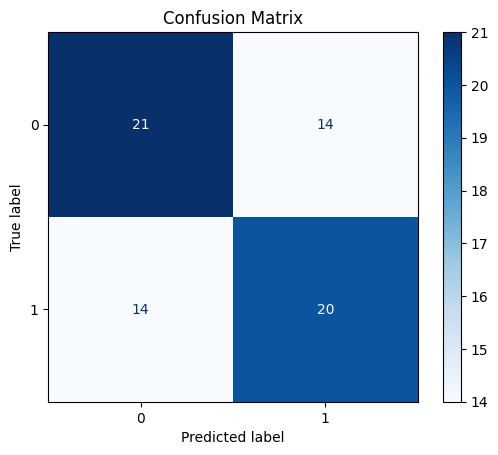

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60        35
           1       0.59      0.59      0.59        34

    accuracy                           0.59        69
   macro avg       0.59      0.59      0.59        69
weighted avg       0.59      0.59      0.59        69



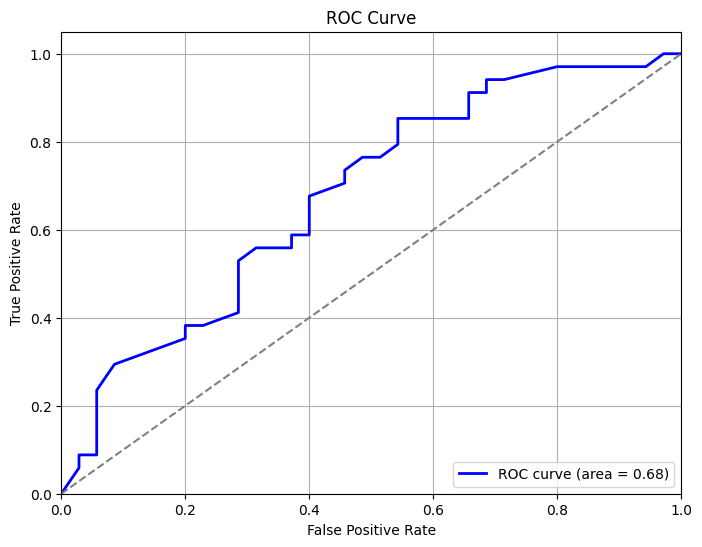

In [2134]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = rf_classifier.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

###### Hyperparamter-Tuned Model

In [2136]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, 4),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}


# Create the Random Forest Classifier
rf_class = RandomForestClassifier(random_state = 29)

# Perform Randomized Search Cross-Validation
random_search_rf_class = RandomizedSearchCV(rf_class, param_distributions = param_dist, n_iter = 100, cv = 10, verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_class.fit(reg_X_train, reg_y_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_class.best_params_)
best_rf_class = random_search_rf_class.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 8, 'min_samples_split': 7, 'n_estimators': 470}


In [2137]:
y_pred_rf = best_rf_class.predict(reg_X_test)

accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.6666666666666666
Confusion Matrix:



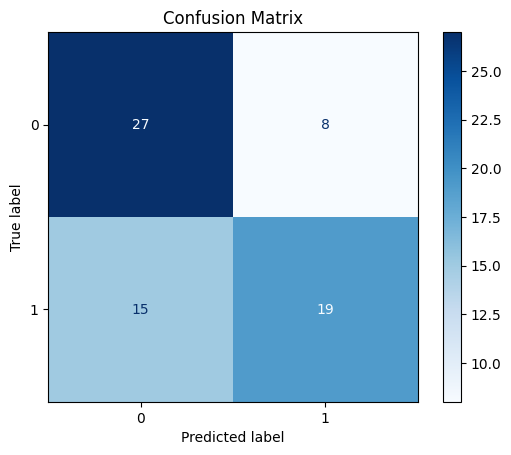

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.77      0.70        35
           1       0.70      0.56      0.62        34

    accuracy                           0.67        69
   macro avg       0.67      0.67      0.66        69
weighted avg       0.67      0.67      0.66        69



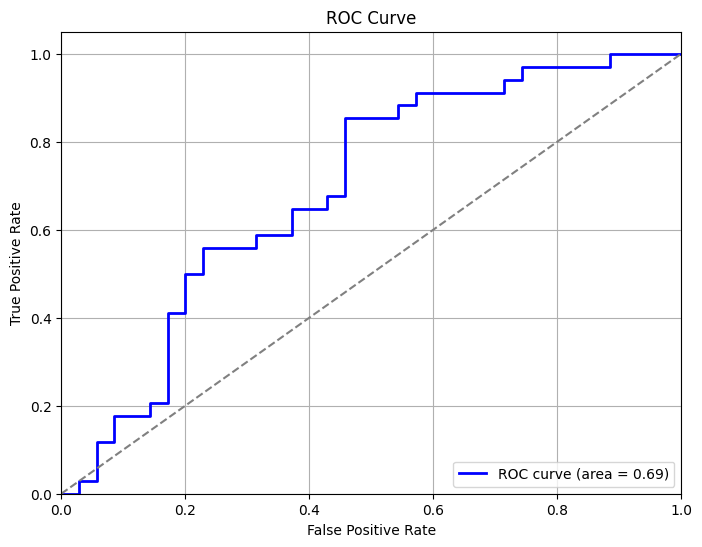

In [2138]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = best_rf_class.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

In [2448]:
# ## Uncomment when a new model is to be added
# ## MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_2_062424_no_spike_offset1.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf_class, file)

##### Strategy II: Predict price (using Random Forrest) then use price to classify

###### Initial Model

In [1873]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

rf_regressor.fit(reg_X_train, reg_y_num_train)

y_pred_rf = rf_regressor.predict(reg_X_test)

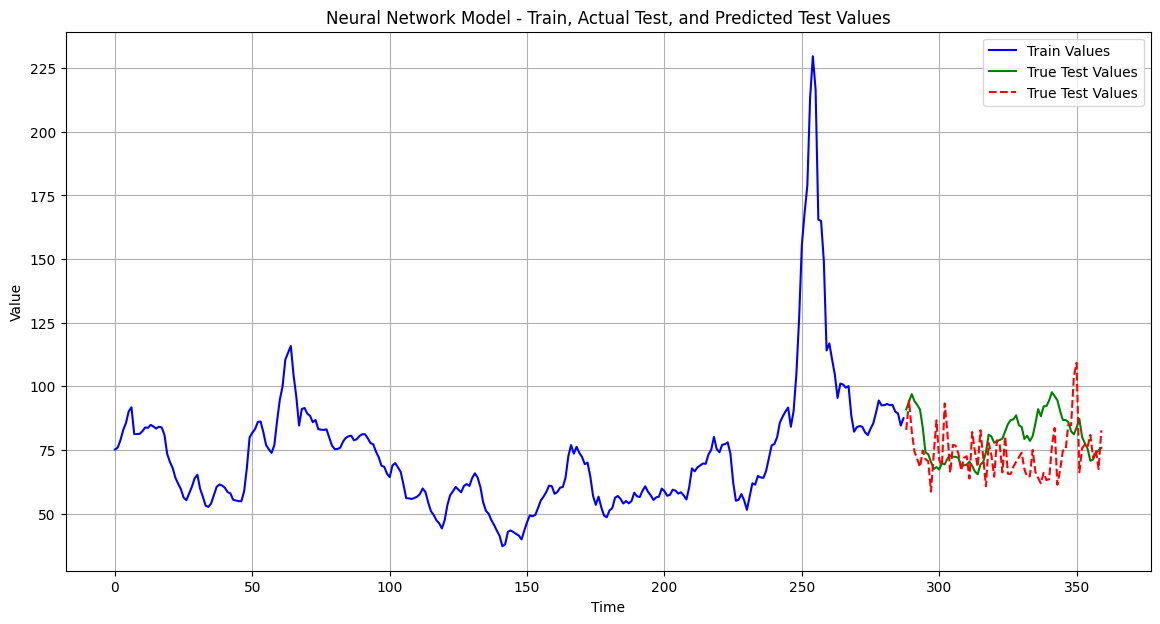

In [1875]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# accuracy = accuracy_score(reg_y_test, y_pred_rf)
# cm = confusion_matrix(reg_y_test, y_pred_rf)
# class_report = classification_report(reg_y_test, y_pred_rf)

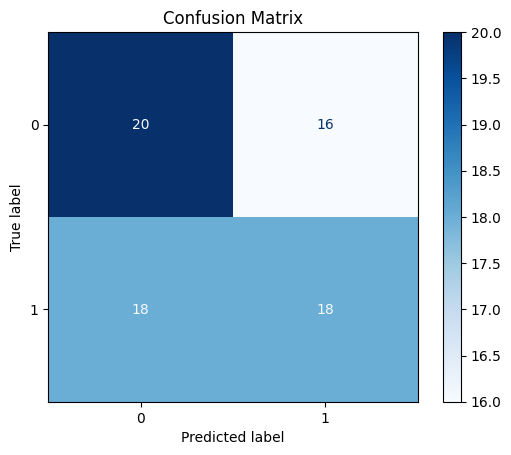

Test Accuracy: 0.5278


In [1881]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparamter-Tuned Model

In [1910]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, X.shape[1]),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

random_search_rf_reg = RandomizedSearchCV(rf_regressor, param_distributions = param_dist, n_iter = n_iter, cv = 4,
                                   verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_reg.fit(reg_X_train, reg_y_num_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_reg.best_params_)
best_rf_reg = random_search_rf_reg.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 12, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 479}


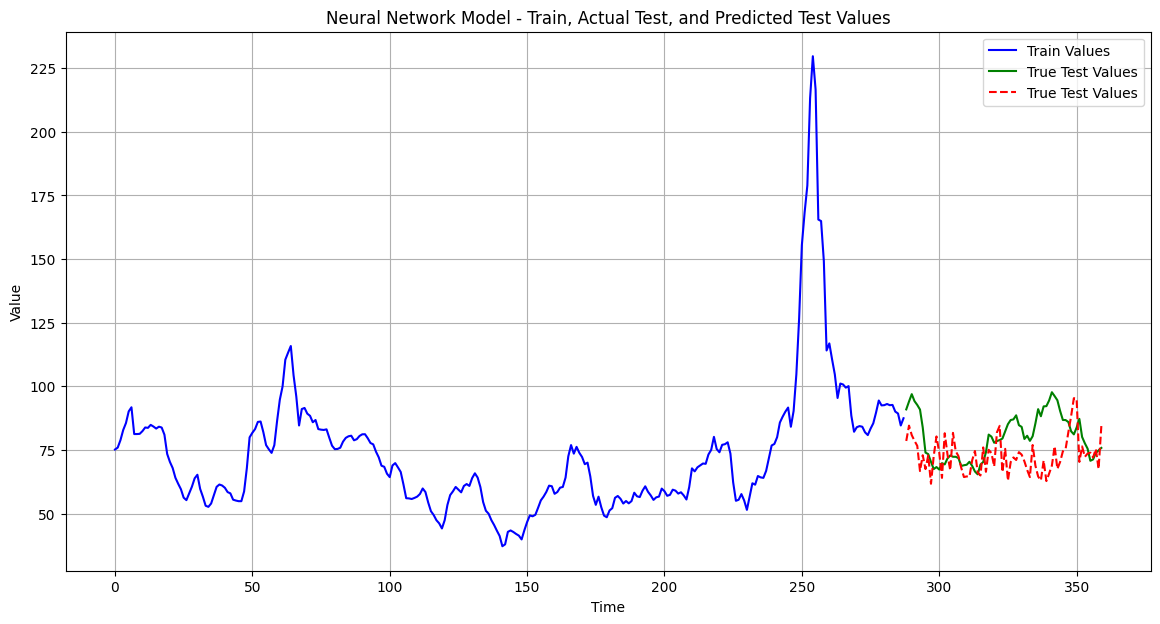

In [1911]:
y_pred_rf = best_rf_reg.predict(reg_X_test)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

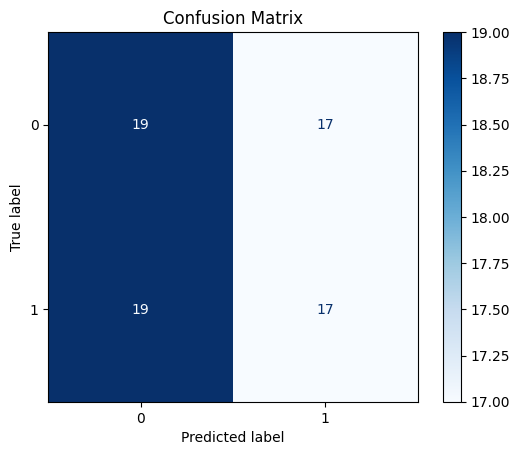

Test Accuracy: 0.5000


In [1912]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

# `Price Offset` = -2

##### Previously Developed Functions

In [19]:
def find_outliers(series):
    '''
    Description
    --------------------------------------------------
    Identifies outliers in a given pandas Series based 
    on the Interquartile Range (IQR) method.
    
    Inputs
    --------------------------------------------------
    + series : pandas.Series; the series for which to 
      identify outliers
    
    Outputs
    --------------------------------------------------
    + Returns a boolean series indicating True for 
      outliers and False for non-outliers.
    '''
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (series < lower_bound) | (series > upper_bound)

In [21]:
### Define the model
def sinusoidal_model(X, A, B, C, D):
    '''
    Description
    --------------------------------------------------
    Constructs a sinusoidal model as a weighted sum of
    sine terms based on the given parameters.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix where 
      each column represents a feature
    + A : list or numpy.ndarray; the amplitudes for 
      each feature's sine term
    + B : list or numpy.ndarray; the frequencies for 
      each feature's sine term
    + C : list or numpy.ndarray; the phase shifts for 
      each feature's sine term
    + D : float; the constant term to be added to the 
      sum of sine terms
    
    Outputs
    --------------------------------------------------
    + Returns the computed sinusoidal function as a 
      numpy array.
    '''
    num_features = X.shape[1] # i.e. num. cols.
    
    ### Initialize the sinusoidal function
    sinusoidal_term = 0
    
    ### Construct the sinusoidal function as a weighted sum of sine terms
    for i in range(num_features):
        sinusoidal_term += A[i] * np.sin(B[i] * X[:, i] + C[i])
    
    ### Add the constant term D
    return sinusoidal_term + D

In [23]:
### Define the objective function for hyperopt
def objective(X, y, params):
    '''
    Description
    --------------------------------------------------
    Defines the objective function for hyperopt to 
    minimize. This function computes the mean squared 
    error between the actual target values and the 
    predicted values from the sinusoidal model.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix where 
      each column represents a feature
    + y : numpy.ndarray; the actual target values
    + params : dict; a dictionary containing the 
      parameters for the sinusoidal model, with keys 
      'A_i', 'B_i', 'C_i' for each feature i, and 'D' 
      for the constant term
    
    Outputs
    --------------------------------------------------
    + Returns the mean squared error (MSE) between 
      the actual target values and the predicted 
      values from the sinusoidal model.
    '''
    num_features = X.shape[1]
    A = [params[f'A_{i}'] for i in range(num_features)]
    B = [params[f'B_{i}'] for i in range(num_features)]
    C = [params[f'C_{i}'] for i in range(num_features)]
    D = params['D']
    
    y_pred = sinusoidal_model(X, A, B, C, D)
    loss = mean_squared_error(y, y_pred)
    return loss

In [25]:
def get_res_df(reg_df, y_preds, idx):
    '''
    Description
    --------------------------------------------------
    Constructs a result DataFrame that includes 
    predictions for the next month's values, current 
    month's values (adjusted), percentage change 
    predictions, and buy signals.
    
    Inputs
    --------------------------------------------------
    + reg_df : pandas.DataFrame; the original 
      regression DataFrame containing historical data
    + y_preds : numpy.ndarray; the predicted values 
      for the next month
    + idx : pandas.Index; the index for the resulting 
      DataFrame
    
    Outputs
    --------------------------------------------------
    + Returns a pandas DataFrame with predictions and 
      calculated fields.
    '''
    res_df = pd.DataFrame(index = idx)
    res_df[f'{cotton_col}_next_month_pred'] = y_preds

    ### Deals with values outside of validation range
    curr_val = [res_df[f'{cotton_col}_next_month_pred'][i] if i in res_df[f'{cotton_col}_next_month_pred'].index else reg_df[cotton_col][i + 1] for i in res_df[f'{cotton_col}_next_month_pred'].index - 1]
    res_df[f'{cotton_col}_curr_month_pred'] = curr_val

    res_df['next_month_pct_change_pred'] = res_df.apply(lambda row : 100 * (row[[f'{cotton_col}_next_month_pred']] - row[f'{cotton_col}_curr_month_pred']) / row[f'{cotton_col}_curr_month_pred'], axis = 1)
    res_df['buy_true'] = reg_df.iloc[train_boundary :, list(reg_df.columns).index('buy')].values
    res_df['buy_pred'] = (res_df['next_month_pct_change_pred'] > 0).astype(int)
    
    return res_df

In [27]:
### Function to create a Keras classification model
def create_nn_class_model(epochs, batch_size, learning_rate = 0.001, dropout_rate = 0.5, num_layers = 2, num_nodes = 16):
    '''
    Description
    --------------------------------------------------
    Creates and compiles a Keras neural network model 
    for binary classification.
    
    Inputs
    --------------------------------------------------
    + epochs : int; the number of epochs for training
    + batch_size : int; the batch size for training
    + learning_rate : float, default=0.001; the 
      learning rate for the Adam optimizer
    + dropout_rate : float, default=0.5; the dropout 
      rate for regularization
    + num_layers : int, default=2; the number of 
      hidden layers in the model
    + num_nodes : int, default=16; the number of nodes 
      in each hidden layer
    
    Outputs
    --------------------------------------------------
    + Returns the compiled Keras model.
    '''
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Function to create a Keras regression model
def create_nn_reg_model(epochs, batch_size, learning_rate = 0.001, dropout_rate = 0.5, num_layers = 2, num_nodes = 16):
    '''
    Description
    --------------------------------------------------
    Creates and compiles a Keras neural network model 
    for regression.
    
    Inputs
    --------------------------------------------------
    + epochs : int; the number of epochs for training
    + batch_size : int; the batch size for training
    + learning_rate : float, default=0.001; the 
      learning rate for the Adam optimizer
    + dropout_rate : float, default=0.5; the dropout 
      rate for regularization
    + num_layers : int, default=2; the number of 
      hidden layers in the model
    + num_nodes : int, default=16; the number of nodes 
      in each hidden layer
    
    Outputs
    --------------------------------------------------
    + Returns the compiled Keras model.
    '''
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=X_train.shape[1], activation='relu'))
    for _ in range(num_layers - 1):
        model.add(Dense(num_nodes, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [29]:
### Function to sample random hyperparameters
def sample_hyperparameters(param_dist):
    '''
    Description
    --------------------------------------------------
    Samples random hyperparameters from the given 
    parameter distributions.
    
    Inputs
    --------------------------------------------------
    + param_dist : dict; a dictionary containing the 
      distributions for each hyperparameter
    
    Outputs
    --------------------------------------------------
    + Returns a dictionary of sampled hyperparameters.
    '''
    params = {}
    for key, dist in param_dist.items():
        if hasattr(dist, 'rvs'):
            params[key] = dist.rvs()
        else:
            params[key] = np.random.choice(dist)
    return params

### Function to perform Randomized Search CV
def RandomCV(X, y, param_dist, reg = False, n_iter = 20, cv = 4, random_state = 29, verbose = 0):
    '''
    Description
    --------------------------------------------------
    Performs Randomized Search Cross-Validation to 
    find the best hyperparameters for a Keras model.
    
    Inputs
    --------------------------------------------------
    + X : numpy.ndarray; the input data matrix
    + y : numpy.ndarray; the target values
    + param_dist : dict; a dictionary containing the 
      distributions for each hyperparameter
    + reg : bool, default=False; flag indicating 
      whether the task is regression (True) or 
      classification (False)
    + n_iter : int, default=20; the number of 
      iterations for the random search
    + cv : int, default=4; the number of folds for 
      cross-validation
    + random_state : int, default=29; the random seed 
      for reproducibility
    + verbose : int, default=0; the verbosity level 
      for printing progress
    
    Outputs
    --------------------------------------------------
    + Returns the best model and the best parameters 
      found during the search.
    '''
    np.random.seed(random_state)
    tf.random.set_seed(random_state)
    
    best_score = -np.inf
    best_params = None
    best_model = None
    
    for i in range(n_iter):
        # Sample random hyperparameters
        params = sample_hyperparameters(param_dist)
        
        ### Iterations Displayed Every 10
        if verbose == 0:
            if i % 10 == 0:
                print(f"Iteration {i+1}/{n_iter}")
        
        ### Displayed every time
        else:   
            print(f"Iteration {i+1}/{n_iter}")
            print(f"Sampled parameters: {params}")
        
        # Cross-validation
        kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        cv_scores = []
        
        for train_index, val_index in kf.split(X):
            X_train_cv, X_val_cv = X[train_index], X[val_index]
            y_train_cv, y_val_cv = y[train_index], y[val_index]
            
            if reg:
                model = create_nn_reg_model(**params)
                model.fit(X_train_cv, y_train_cv, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
                y_pred = model.predict(X_val_cv)
                
                ### We want to get the highest accuracy
                ### mse is not as important
                res_df = get_res_df(reg_df, y_pred, idx = val_index)
                accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
                cv_scores.append(accuracy)
            else:
                model = create_nn_class_model(**params)
                model.fit(X_train_cv, y_train_cv, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
                val_loss, val_acc = model.evaluate(X_val_cv, y_val_cv, verbose=0)
                cv_scores.append(val_acc)
        
        mean_cv_score = np.mean(cv_scores)
        print(f"Mean CV score: {mean_cv_score:.4f}")
        
        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_params = params
            best_model = model
    
    print(f"Best CV score: {best_score:.4f} with parameters: {best_params}")
    return best_model, best_params

##### Prepare `cotton_prices`

In [97]:
### Make Sure Cotton Prices Reset Every Time
path = './data/economic_data/cotton_prices_1990_2024.csv'
cotton_prices = pd.read_csv(path)

price_offset = -2
cotton_prices['DATE'] = pd.to_datetime(cotton_prices['DATE'])
cotton_prices = cotton_prices[cotton_prices['DATE'] <= pd.to_datetime('2020-01-01')]
cotton_col = 'PCOTTINDUSDM'
cotton_prices[f'{cotton_col}_next_month'] = cotton_prices[cotton_col].shift(price_offset)
cotton_prices['next_month_pct_change'] = cotton_prices.apply(lambda row : 100 * (row[[f'{cotton_col}_next_month']] - row[cotton_col]) / row[cotton_col], axis = 1)
cotton_prices = cotton_prices.dropna(subset = [f'{cotton_col}_next_month'])
cotton_prices['buy'] = (cotton_prices['next_month_pct_change'] > 0).astype(int)

##### Add price_data for `cd_rel`'s

In [98]:
col = 'buy'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = cotton_col
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = f'{cotton_col}_next_month'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

col = 'next_month_pct_change'
cd_rel_full[col] = cotton_prices[col]
cd_rel_3ytd[col] = cotton_prices[col]
cd_rel_1ytd[col] = cotton_prices[col]

### Model Development

**All Data**

In [99]:
### All Data
df = cd_rel_full.dropna()
X = df.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y = df['buy']

### Numeric Version of y: Price of Cotton
y_num = df[cotton_col]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df))
X_train, X_test = X_scaled.iloc[: train_boundary, :], X_scaled.iloc[train_boundary :, :]
y_train, y_test = y.iloc[: train_boundary], y.iloc[train_boundary :]

y_num_train, y_num_test = y_num.iloc[: train_boundary], y_num.iloc[train_boundary :]

**Outlier Exclusive**

In [101]:
### Outlier Exclusive
### Gets rid of outliers
col = 'next_month_pct_change'

outliers_idx = find_outliers(df[col])

df_no_outliers = df[~outliers_idx].reset_index()


X_no_outliers = df_no_outliers.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y_no_outliers = df_no_outliers['buy']

### Numeric Version of y: Price of Cotton
y_num_no_outliers = df_no_outliers[cotton_col]

scaler = StandardScaler()
X_scaled_no_outliers = pd.DataFrame(scaler.fit_transform(X_no_outliers))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df_no_outliers))
X_train_no_outliers, X_test_no_outliers = X_scaled_no_outliers.iloc[: train_boundary, :], X_scaled_no_outliers.iloc[train_boundary :, :]
y_train_no_outliers, y_test_no_outliers = y_no_outliers.iloc[: train_boundary], y_no_outliers.iloc[train_boundary :]

y_num_train_no_outliers, y_num_test_no_outliers = y_num_no_outliers.iloc[: train_boundary], y_num_no_outliers.iloc[train_boundary :]

**Spike Exclusive**

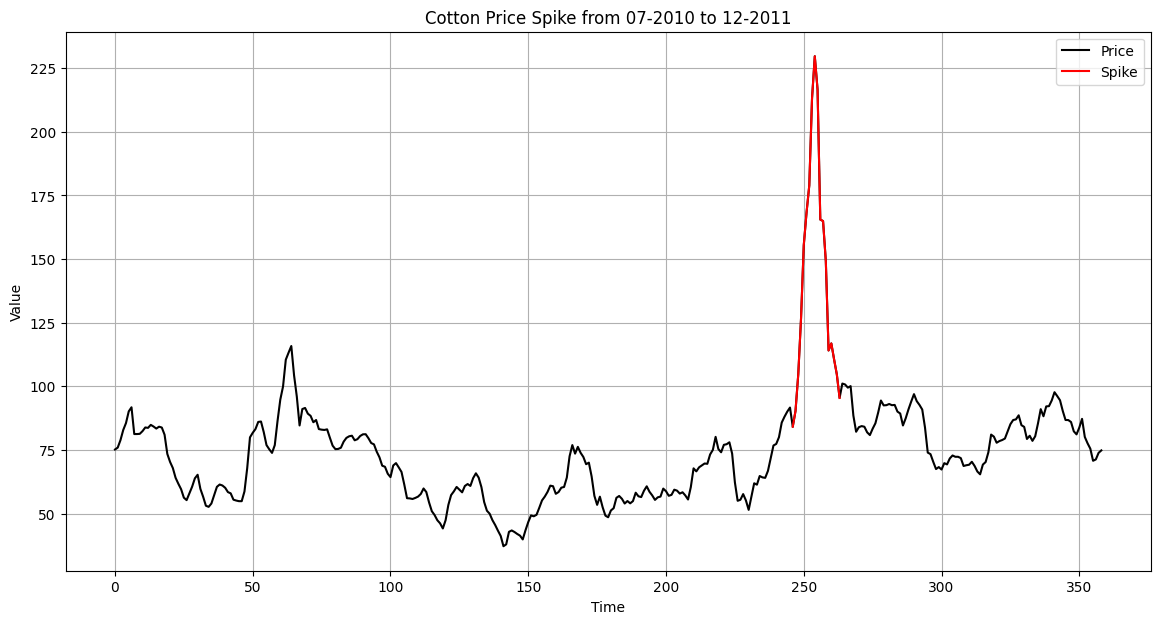

In [102]:
spike = df.iloc[246:264]
spike_idx = spike.index
plt.figure(figsize=(14, 7))

plt.plot(df.index, df['PCOTTINDUSDM'], label='Price', color='black')

plt.plot(spike.index, spike['PCOTTINDUSDM'], label='Spike', color='red')

plt.title(f"Cotton Price Spike from {spike['month'].values[0]:02}-{spike['year'].values[0]:02} to {spike['month'].values[-1]:02}-{spike['year'].values[-1]:02}")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
df_no_spike = df[~df.index.isin(spike_idx)]


X_no_spike = df_no_spike.drop(columns = ['year', 'buy', cotton_col, f'{cotton_col}_next_month', 'next_month_pct_change']) 
y_no_spike = df_no_spike['buy']

### Numeric Version of y: Price of Cotton
y_num_no_spike = df_no_spike[cotton_col]

scaler = StandardScaler()
X_scaled_no_spike = pd.DataFrame(scaler.fit_transform(X_no_spike))

### Split the data periodically so that models can be compared against times series
test_size = 0.2
train_boundary = int((1 - test_size) * len(df_no_spike))
X_train_no_spike, X_test_no_spike = X_scaled_no_spike.iloc[: train_boundary, :], X_scaled_no_spike.iloc[train_boundary :, :]
y_train_no_spike, y_test_no_spike = y_no_spike.iloc[: train_boundary], y_no_spike.iloc[train_boundary :]

y_num_train_no_spike, y_num_test_no_spike = y_num_no_spike.iloc[: train_boundary], y_num_no_spike.iloc[train_boundary :]

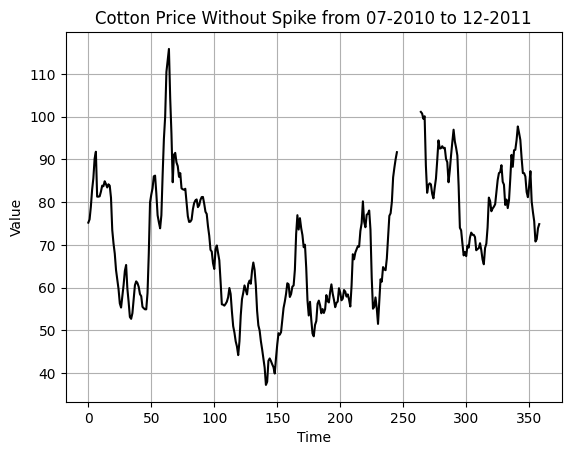

In [104]:
plt.plot(df_no_spike.loc[:spike_idx[0]].index, df_no_spike.loc[:spike_idx[0],'PCOTTINDUSDM'], color='black')

plt.plot(df_no_spike.loc[spike_idx[-1]:].index, df_no_spike.loc[spike_idx[-1]:,'PCOTTINDUSDM'], color='black')

plt.title(f"Cotton Price Without Spike from {spike['month'].values[0]:02}-{spike['year'].values[0]:02} to {spike['month'].values[-1]:02}-{spike['year'].values[-1]:02}")
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## All Data

#### Basic Regression

##### Strategy I: Direct Classification (Logistic Regression)

In [105]:
remove_outliers = False
remove_spike = False

if remove_outliers:
    train_boundary = int((1 - test_size) * len(df_no_outliers))
    reg_df = df_no_outliers
    reg_X_train = X_train_no_outliers
    reg_y_train = y_train_no_outliers
    reg_y_num_train = y_num_train_no_outliers
    
    reg_X_test = X_test_no_outliers
    reg_y_test = y_test_no_outliers
    reg_y_num_test = y_num_test_no_outliers
else:
    train_boundary = int((1 - test_size) * len(df))
    reg_df = df
    reg_X_train = X_train
    reg_y_train = y_train
    reg_y_num_train = y_num_train
    
    reg_X_test = X_test
    reg_y_test = y_test
    reg_y_num_test = y_num_test
    
if remove_spike:
    train_boundary = int((1 - test_size) * len(df_no_spike))
    reg_df = df_no_spike
    reg_X_train = X_train_no_spike
    reg_y_train = y_train_no_spike
    reg_y_num_train = y_num_train_no_spike
    
    reg_X_test = X_test_no_spike
    reg_y_test = y_test_no_spike
    reg_y_num_test = y_num_test_no_spike

In [ ]:
log_reg = LogisticRegression(random_state = 29)

log_reg.fit(reg_X_train, reg_y_train)

y_pred_proba = log_reg.predict_proba(reg_X_test)[:, 1]

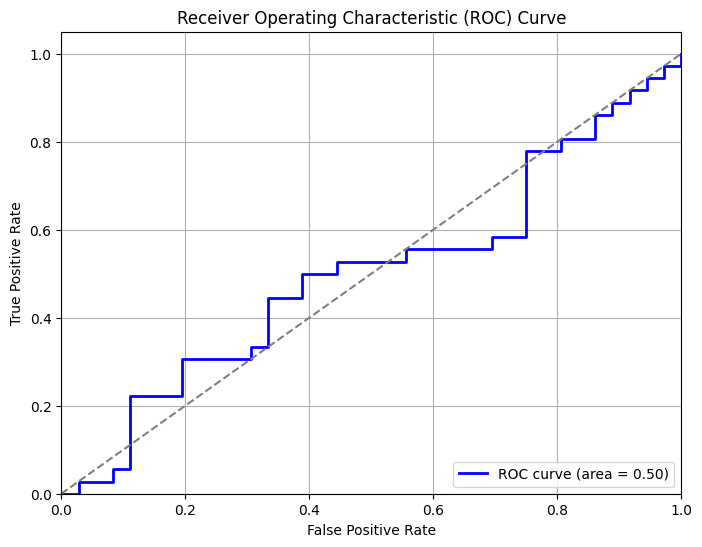

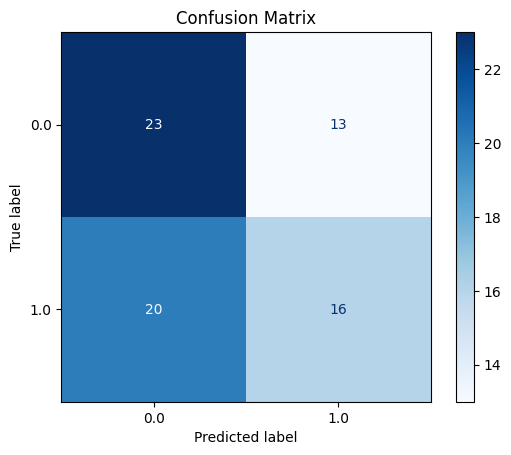

Test Accuracy: 0.5417
Training Accuracy: 0.9756


In [41]:
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Confusion matrix
y_pred = log_reg.predict(reg_X_test)
cm = confusion_matrix(reg_y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Accuracy
accuracy = accuracy_score(reg_y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Training accuracy
train_accuracy = accuracy_score(reg_y_train, log_reg.predict(reg_X_train))
print(f'Training Accuracy: {train_accuracy:.4f}')

##### Strategy II: Predict price (using Sinusoidal Regression) then use price to classify

In [2507]:
### Set up hyperopt
X = reg_X_train.values
y = reg_y_num_train.values
num_features = X.shape[1]
space = {
    **{f'A_{i}': hp.uniform(f'A_{i}', 0, 2) for i in range(num_features)},
    **{f'B_{i}': hp.uniform(f'B_{i}', 0, 2) for i in range(num_features)},
    **{f'C_{i}': hp.uniform(f'C_{i}', 0, 2 * np.pi) for i in range(num_features)},
    'D': hp.uniform('D', -1, 1)
}

trials = Trials()
best = fmin(fn=lambda params: objective(X, y, params),
            space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████████████████████████████████████████| 100/100 [11:08<00:00,  6.69s/trial, best loss: 1018.6274322025748]


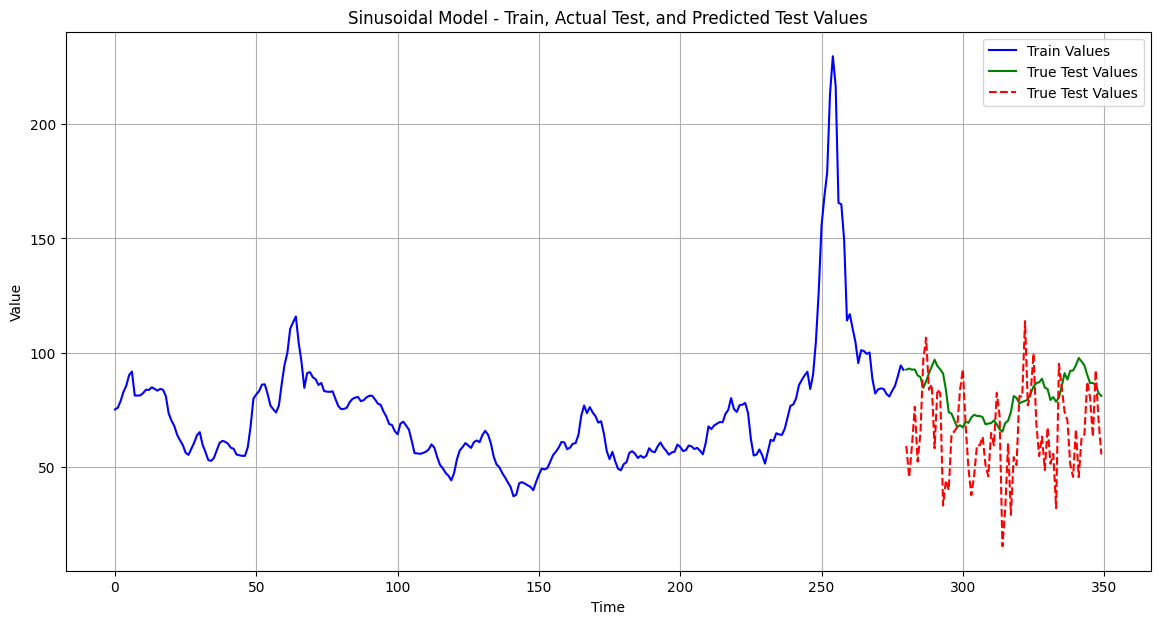

In [2508]:
### Evaluate the results
best_A = [best[f'A_{i}'] for i in range(num_features)]
best_B = [best[f'B_{i}'] for i in range(num_features)]
best_C = [best[f'C_{i}'] for i in range(num_features)]
best_D = best['D']

y_pred_sin = sinusoidal_model(reg_X_test.values, best_A, best_B, best_C, best_D)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_sin, label='True Test Values', color='red', ls = '--')

plt.title('Sinusoidal Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [2509]:
train_idx = range(train_boundary)
test_idx = range(train_boundary, len(reg_df))

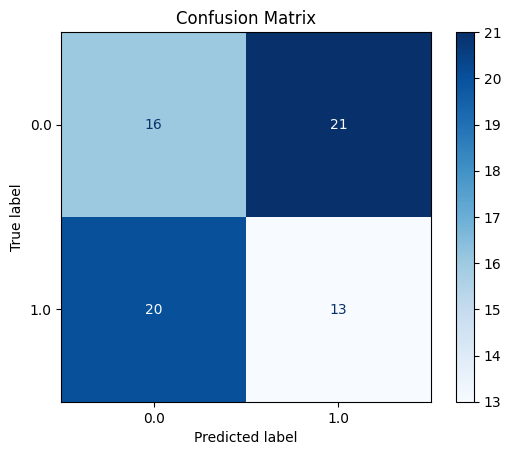

Test Accuracy: 0.4143


In [2510]:
res_df = get_res_df(reg_df, y_pred_sin, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Time Series

In [2512]:
y_ts = reg_df[f'{cotton_col}_next_month']
y_ts_train, y_ts_test = y_ts.iloc[: train_boundary], y_ts.iloc[train_boundary :]

In [2513]:
m = 12
SARIMAXmodel = SARIMAX(y_ts_train, order = (4, 2, 3), seasonal_order=(2,2,2,m))
SARIMAXmodel = SARIMAXmodel.fit(disp=0)

In [2514]:
y_pred_ts = SARIMAXmodel.predict(start = y_ts_test.index[0], end = y_ts_test.index[-1])

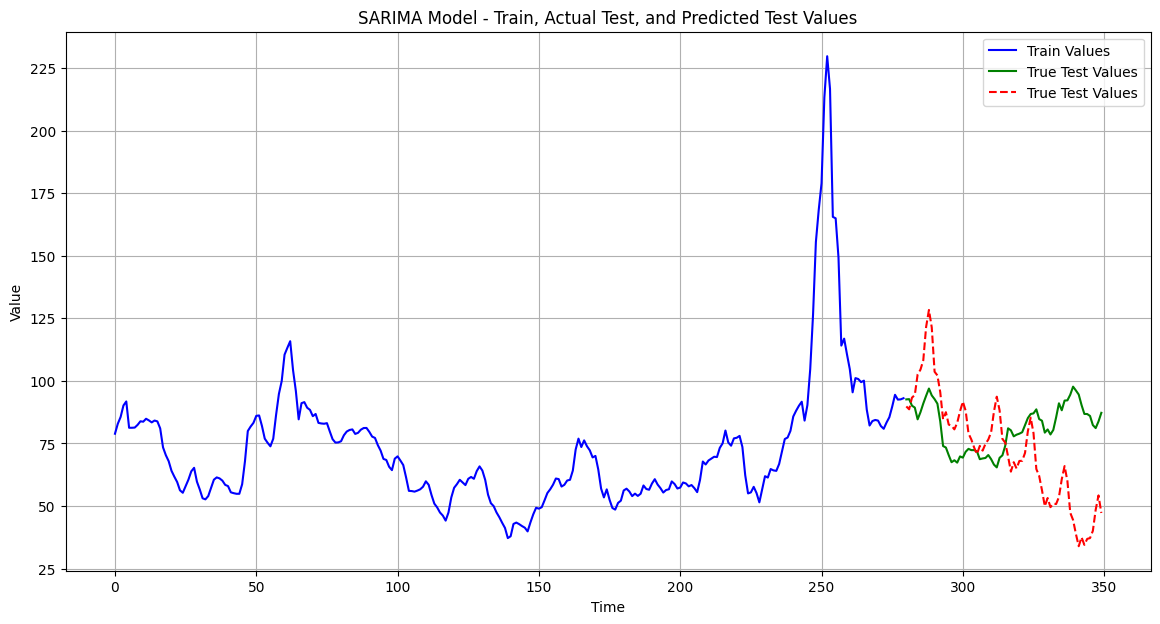

In [2515]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_ts_train)), y_ts_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_ts_train), len(y_ts_train) + len(y_ts_test)), y_ts_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_ts_train), len(y_ts_train) + len(y_ts_test)), y_pred_ts, label='True Test Values', color='red', ls = '--')

plt.title('SARIMA Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

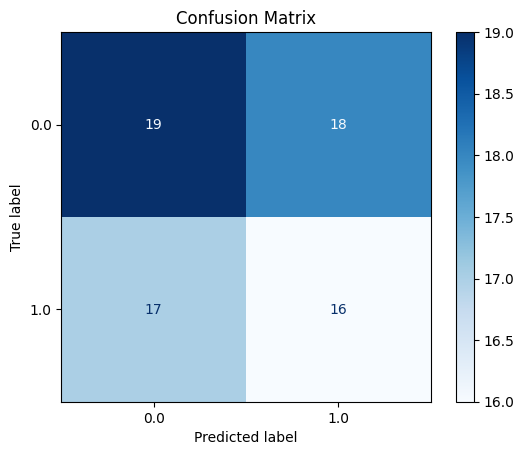

Test Accuracy: 0.5000


In [2516]:
res_df = get_res_df(reg_df, y_pred_ts, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Neural Network

##### Strategy I: Direct Classification (Neural Network)

###### Initial Model

In [42]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [43]:
# num_epochs = 20
# batch_size = 32

# model = Sequential([
#     Dense(16, input_dim=X.shape[1], activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(32, activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation ==> binary classification
# ])

# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

# history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

# train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

# print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

### This is the best model I have gotten so far
model_path = './models/nn_buy_cotton_classification_model_1_062224_full_data_offset1.pkl'

# Load the model
with open(model_path, 'rb') as f:
    model = pickle.load(f)
    
num_epochs = 4
batch_size = 32
history = model.fit(reg_X_train, reg_y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(reg_X_test, reg_y_test), verbose = 0)

train_loss, train_acc = model.evaluate(reg_X_train, reg_y_train, verbose = 0)
test_loss, test_acc = model.evaluate(reg_X_test, reg_y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")




Train Accuracy: 0.6794, Train Loss: 0.6039
Test Accuracy: 0.7083, Test Loss: 0.5957


3/3 [==============================] - 0s 2ms/step


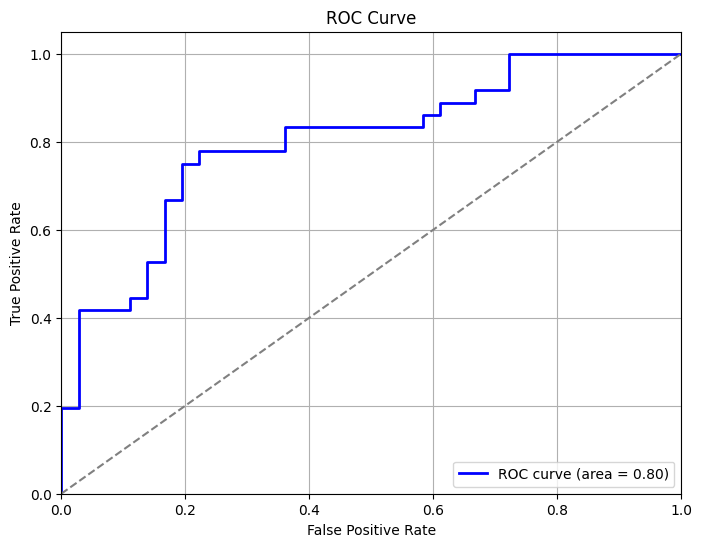

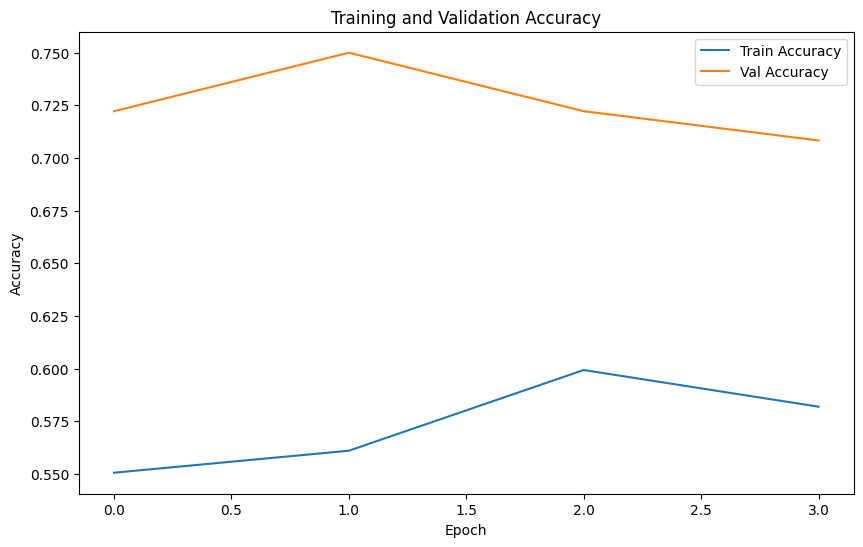

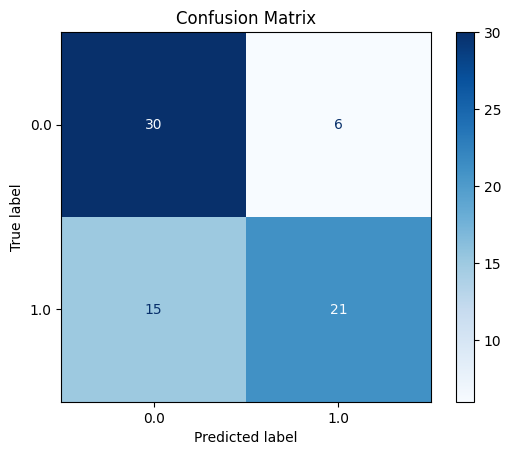

In [44]:
### Predictions
threshold = 0.5
y_pred_proba = model.predict(reg_X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(reg_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

In [109]:
y_pred_proba = model.predict(reg_X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)
class_report = classification_report(reg_y_test, y_pred)
print("Classification Report:\n", class_report)

3/3 [==============================] - 0s 1ms/step
Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.83      0.74        36
         1.0       0.78      0.58      0.67        36

    accuracy                           0.71        72
   macro avg       0.72      0.71      0.70        72
weighted avg       0.72      0.71      0.70        72



###### Hyperparmeter-Tuned Model 

Since `RandomizedSearchCV` & `GridSearchCV` were giving me issues, I manually finetuned the hyperparameters.

In [2575]:
n_iter = 100
X = X_train.values
y = y_train.values
param_dist = {
    'learning_rate': uniform(0.001, 0.1),  
    'dropout_rate': uniform(0, 0.7),     
    'num_layers': [1, 2, 3],               
    'num_nodes': [16, 32, 64],             
    'epochs': [10, 20, 30, 40],                
    'batch_size': [16, 32, 64]             
}
best_model, best_params = RandomCV(X, y, param_dist, reg = False, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
Mean CV score: 0.4714
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.4750
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
Mean CV score: 0.5143
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.5214
Iteration 5/100
Sampled parameters: {'learning_rate': 0.0850919735388559, 'dropout_rate': 0.5664073940705749, 'num_layers': 3, 'num_nodes': 64, 'epochs': 20, 'batch_size': 64}
Mean CV score: 0.4714
Ite

In [77]:
#### Performance Evaluation
history = best_model.fit(reg_X_train, reg_y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(reg_X_test, reg_y_test), verbose = 0)

train_loss, train_acc = best_model.evaluate(reg_X_train, reg_y_train, verbose = 0)
test_loss, test_acc = best_model.evaluate(reg_X_test, reg_y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

threshold = 0.5
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(reg_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

##### Strategy II: Predict price (using Neural Network) then use price to classify

###### Initial Model

In [2579]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [79]:
num_epochs = 20
batch_size = 32

model = Sequential([
    Dense(16, input_dim=X.shape[1], activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(16, activation='relu'),
    Dense(1)  # No activation ==> Regression
])

model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

model.summary()

history = model.fit(reg_X_train, reg_y_num_train, epochs = num_epochs, batch_size = batch_size, validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_nn = model.predict(reg_X_test)
mse = mean_squared_error(reg_y_num_test, y_pred_nn)

print(f"Mean Squared Error on Test Set: {mse}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                13792     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14881 (58.13 KB)
Trainable params: 14881 (

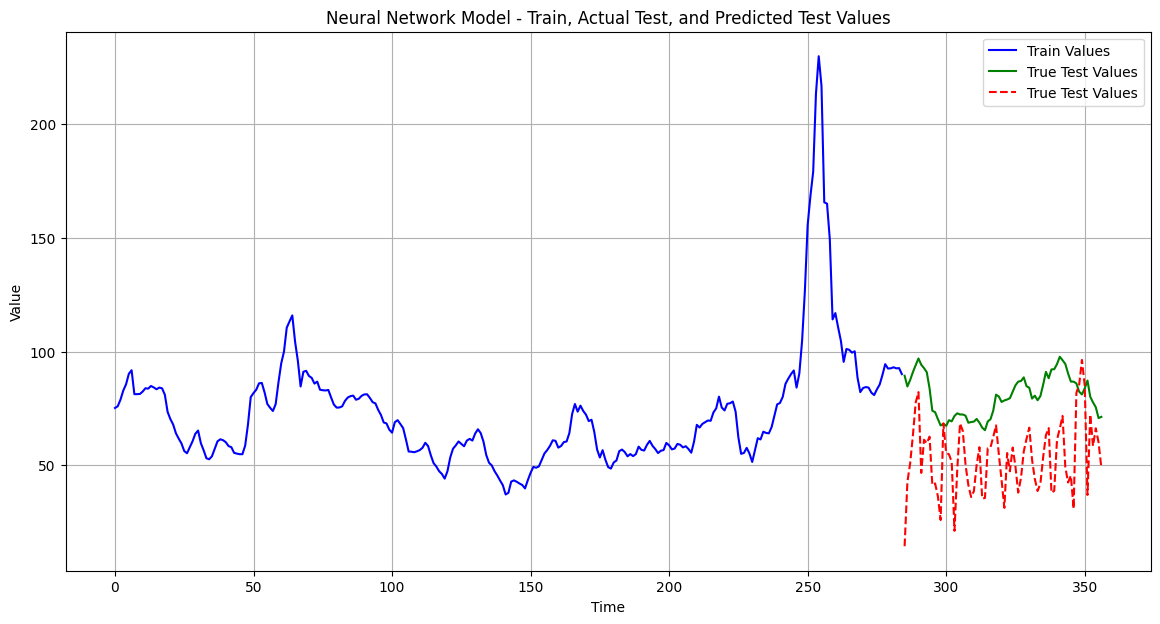

In [81]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_nn, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

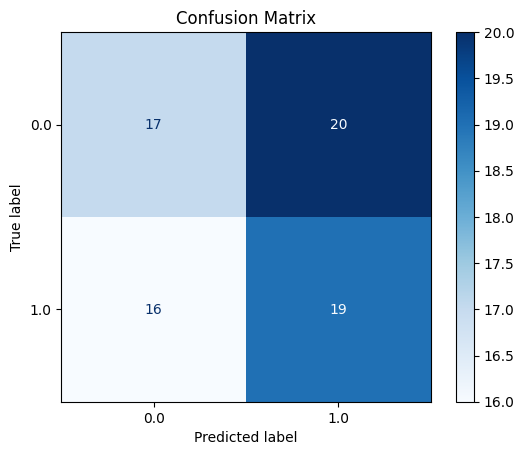

Test Accuracy: 0.5000


In [83]:
res_df = get_res_df(reg_df, y_pred_nn.flatten(), idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparmeter-Tuned Model

In [2584]:
X = X_train.values
y = y_num_train.values
best_model, best_params = RandomCV(X, y, param_dist, reg = True, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
3/3 [==============================] - 0s 2ms/step
Mean CV score: 0.5607
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5964
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5429
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
3/3 [==============================] - 0s 5ms/step
Mean CV score: 0.60

3/3 [==============================] - 0s 4ms/step
Mean CV score: 0.5393
Iteration 25/100
Sampled parameters: {'learning_rate': 0.04870474187586449, 'dropout_rate': 0.6440704253501279, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 64}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5429
Iteration 26/100
Sampled parameters: {'learning_rate': 0.010128181740923257, 'dropout_rate': 0.3896369144646106, 'num_layers': 3, 'num_nodes': 32, 'epochs': 40, 'batch_size': 64}
3/3 [==============================] - 0s 5ms/step
Mean CV score: 0.5679
Iteration 27/100
Sampled parameters: {'learning_rate': 0.03910892098688473, 'dropout_rate': 0.042218186375481324, 'num_layers': 2, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
3/3 [==============================] - 0s 3ms/step
Mean CV score: 0.5500
Iteration 28/100
Sampled parameters: {'learning_rate': 0.04769673620042837, 'dropout_rate': 0.48768270913058703, 'num_layers': 2, 'num_nodes': 32, 'epochs': 20, 'batch_siz

In [2585]:
history = best_model.fit(reg_X_train, reg_y_num_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_best_model = best_model.predict(reg_X_test)
mse_best_model = mean_squared_error(reg_y_num_test, y_pred_best_model)

print(f"Mean Squared Error on Test Set: {mse}")

3/3 [==============================] - 0s 3ms/step
Mean Squared Error on Test Set: 1206.3702267602562


In [87]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_best_model, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

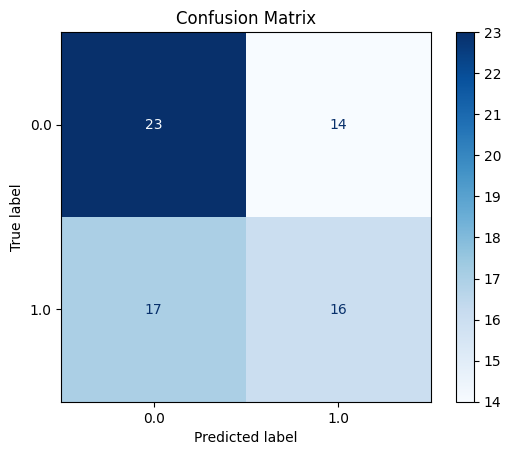

Test Accuracy: 0.5571


In [2587]:
res_df = get_res_df(reg_df, y_pred_best_model, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Random Forrest

##### Strategy I: Direct Classification (Random Forrest)

###### Initial Model

In [50]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state = 29)

# Train the model
rf_classifier.fit(reg_X_train, reg_y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(reg_X_test)

# Evaluate the model
accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.6666666666666666
Confusion Matrix:



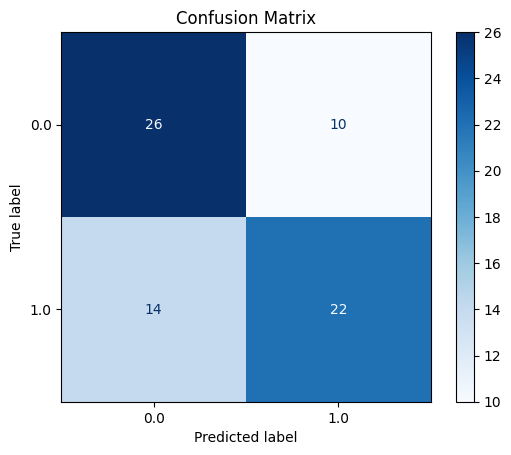

Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.72      0.68        36
         1.0       0.69      0.61      0.65        36

    accuracy                           0.67        72
   macro avg       0.67      0.67      0.67        72
weighted avg       0.67      0.67      0.67        72



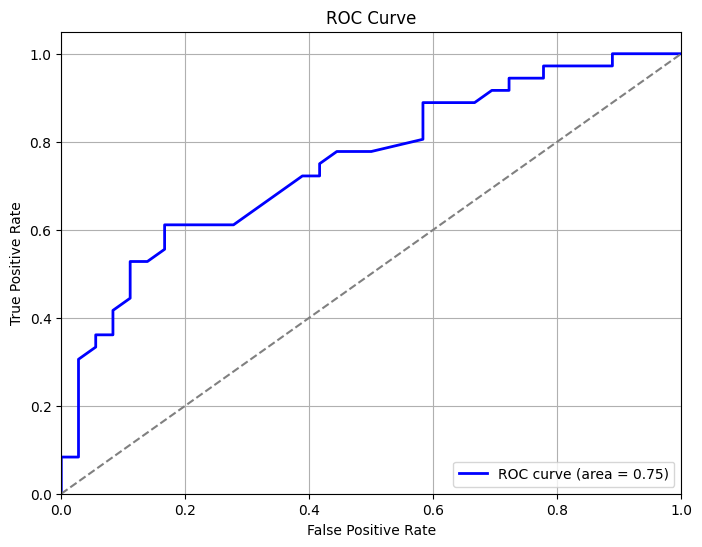

In [51]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = rf_classifier.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

In [52]:
# ## Uncomment when a new model is to be added
# ## MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_1_062524_full_data_offset2.pkl.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(rf_classifier, file)

###### Hyperparamter-Tuned Model

In [53]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, 4),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}


# Create the Random Forest Classifier
rf_class = RandomForestClassifier(random_state = 29)

# Perform Randomized Search Cross-Validation
random_search_rf_class = RandomizedSearchCV(rf_class, param_distributions = param_dist, n_iter = 100, cv = 10, verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_class.fit(reg_X_train, reg_y_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_class.best_params_)
best_rf_class = random_search_rf_class.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 444}


In [54]:
y_pred_rf = best_rf_class.predict(reg_X_test)

accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.7083333333333334
Confusion Matrix:



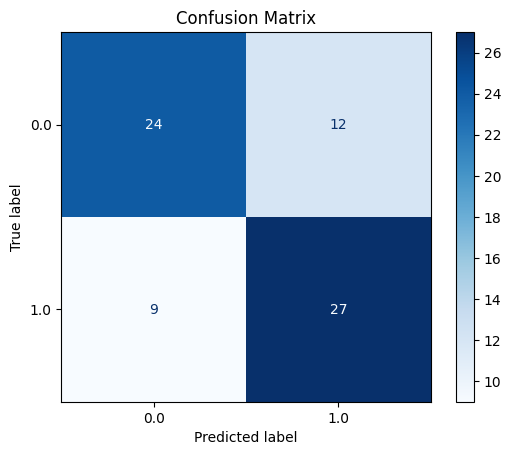

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.67      0.70        36
         1.0       0.69      0.75      0.72        36

    accuracy                           0.71        72
   macro avg       0.71      0.71      0.71        72
weighted avg       0.71      0.71      0.71        72



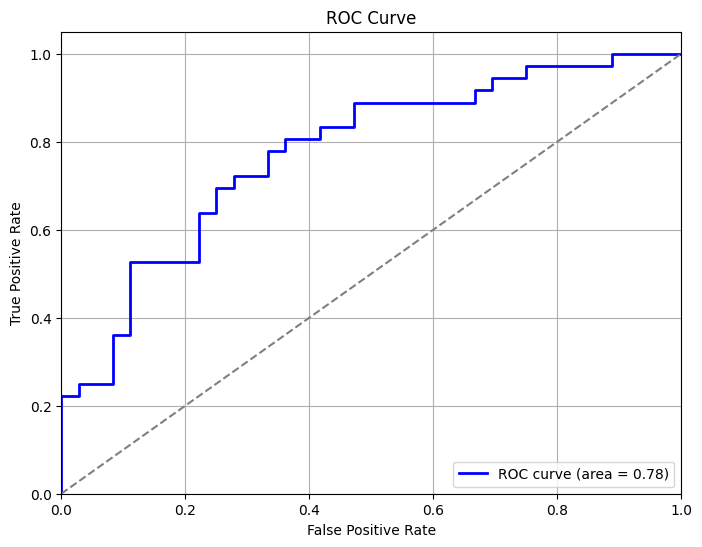

In [55]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = best_rf_class.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

In [56]:
# # ## Uncomment when a new model is to be added
# # ## MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_2_062524_full_data_offset2.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf_class, file)

##### Strategy II: Predict price (using Random Forrest) then use price to classify

###### Initial Model

In [2600]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

rf_regressor.fit(reg_X_train, reg_y_num_train)

y_pred_rf = rf_regressor.predict(reg_X_test)

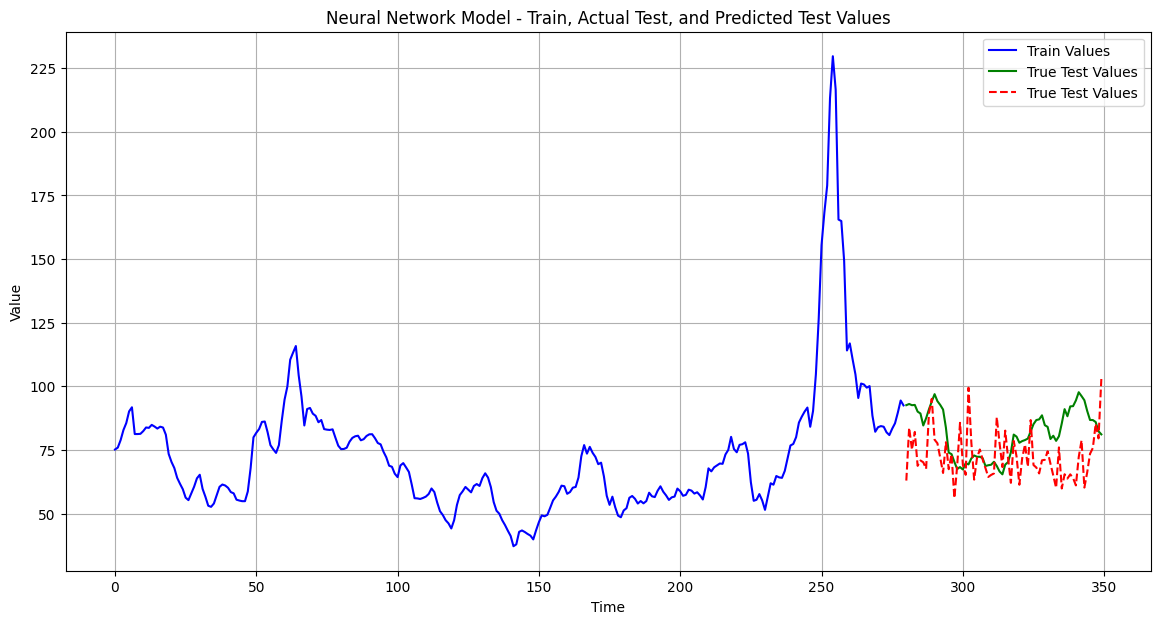

In [2601]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# accuracy = accuracy_score(reg_y_test, y_pred_rf)
# cm = confusion_matrix(reg_y_test, y_pred_rf)
# class_report = classification_report(reg_y_test, y_pred_rf)

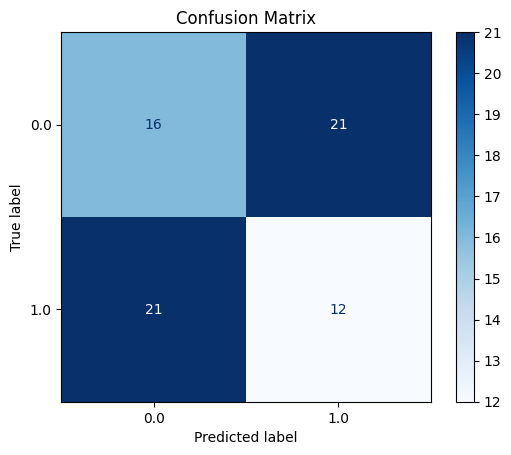

Test Accuracy: 0.4000


In [2602]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparamter-Tuned Model

In [2604]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, X.shape[1]),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

random_search_rf_reg = RandomizedSearchCV(rf_regressor, param_distributions = param_dist, n_iter = n_iter, cv = 4,
                                   verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_reg.fit(reg_X_train, reg_y_num_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_reg.best_params_)
best_rf_reg = random_search_rf_reg.best_estimator_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 12, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 479}


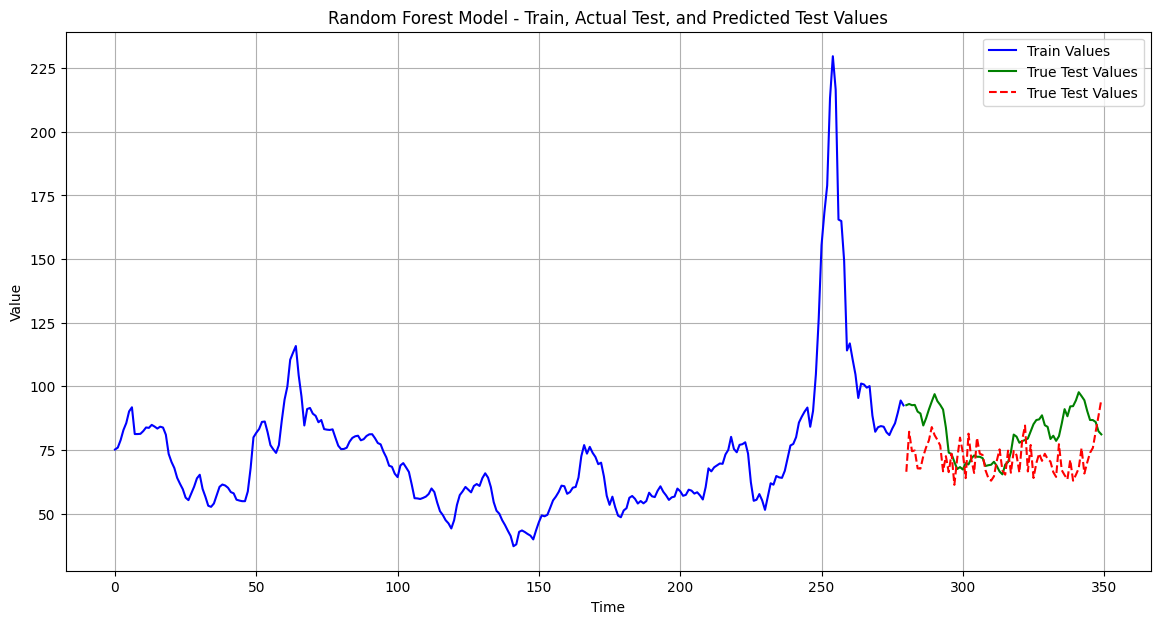

In [2605]:
y_pred_rf = best_rf_reg.predict(reg_X_test)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Random Forest Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

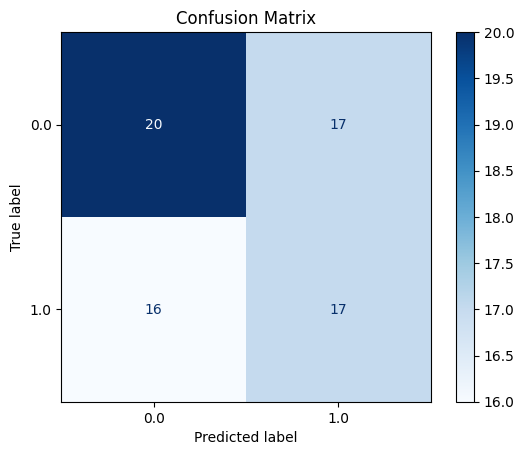

Test Accuracy: 0.5286


In [2606]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

In [2607]:
### Uncomment when a new model is to be added
### MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_1_062324.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf, file)

## Spike Exclusive

#### Basic Regression

##### Strategy I: Direct Classification (Logistic Regression)

In [57]:
remove_outliers = False
remove_spike = True

if remove_outliers:
    train_boundary = int((1 - test_size) * len(df_no_outliers))
    reg_df = df_no_outliers
    reg_X_train = X_train_no_outliers
    reg_y_train = y_train_no_outliers
    reg_y_num_train = y_num_train_no_outliers
    
    reg_X_test = X_test_no_outliers
    reg_y_test = y_test_no_outliers
    reg_y_num_test = y_num_test_no_outliers
else:
    train_boundary = int((1 - test_size) * len(df))
    reg_df = df
    reg_X_train = X_train
    reg_y_train = y_train
    reg_y_num_train = y_num_train
    
    reg_X_test = X_test
    reg_y_test = y_test
    reg_y_num_test = y_num_test
    
if remove_spike:
    train_boundary = int((1 - test_size) * len(df_no_spike))
    reg_df = df_no_spike
    reg_X_train = X_train_no_spike
    reg_y_train = y_train_no_spike
    reg_y_num_train = y_num_train_no_spike
    
    reg_X_test = X_test_no_spike
    reg_y_test = y_test_no_spike
    reg_y_num_test = y_num_test_no_spike
    

log_reg = LogisticRegression(random_state = 29)

log_reg.fit(reg_X_train, reg_y_train)

y_pred_proba = log_reg.predict_proba(reg_X_test)[:, 1]

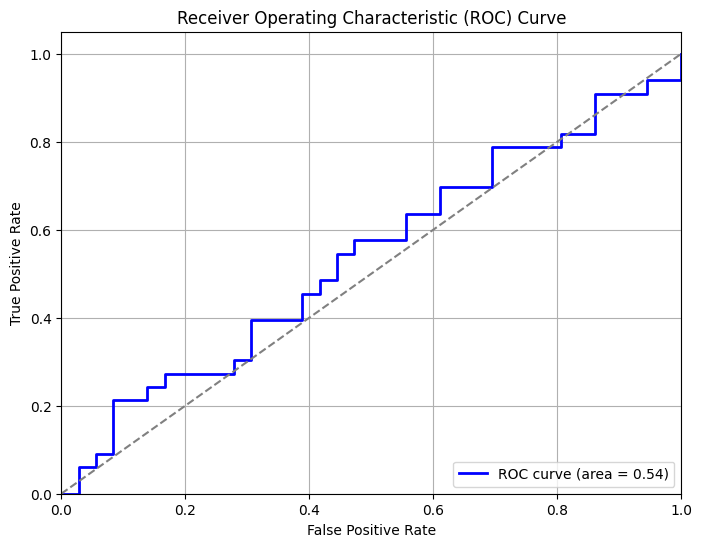

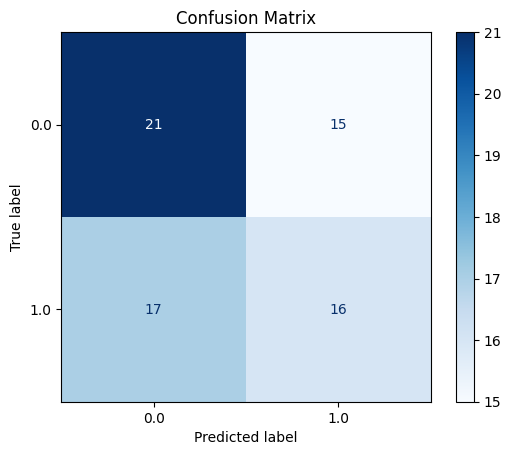

Test Accuracy: 0.5362
Training Accuracy: 0.9816


In [58]:
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Confusion matrix
y_pred = log_reg.predict(reg_X_test)
cm = confusion_matrix(reg_y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Accuracy
accuracy = accuracy_score(reg_y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Training accuracy
train_accuracy = accuracy_score(reg_y_train, log_reg.predict(reg_X_train))
print(f'Training Accuracy: {train_accuracy:.4f}')

##### Strategy II: Predict price (using Sinusoidal Regression) then use price to classify

In [2614]:
### Set up hyperopt
X = reg_X_train.values
y = reg_y_num_train.values
num_features = X.shape[1]
space = {
    **{f'A_{i}': hp.uniform(f'A_{i}', 0, 2) for i in range(num_features)},
    **{f'B_{i}': hp.uniform(f'B_{i}', 0, 2) for i in range(num_features)},
    **{f'C_{i}': hp.uniform(f'C_{i}', 0, 2 * np.pi) for i in range(num_features)},
    'D': hp.uniform('D', -1, 1)
}

trials = Trials()
best = fmin(fn=lambda params: objective(X, y, params),
            space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|███████████████████████████████████████████████| 100/100 [26:50<00:00, 16.10s/trial, best loss: 606.4774832072652]


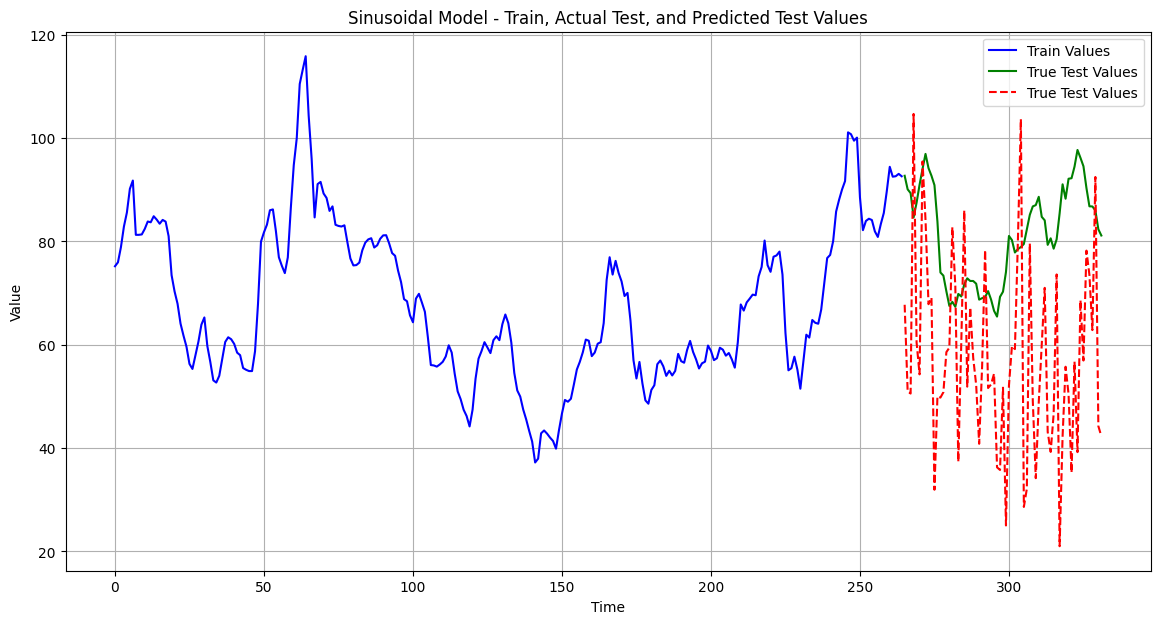

In [2615]:
### Evaluate the results
best_A = [best[f'A_{i}'] for i in range(num_features)]
best_B = [best[f'B_{i}'] for i in range(num_features)]
best_C = [best[f'C_{i}'] for i in range(num_features)]
best_D = best['D']

y_pred_sin = sinusoidal_model(reg_X_test.values, best_A, best_B, best_C, best_D)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_sin, label='True Test Values', color='red', ls = '--')

plt.title('Sinusoidal Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [2616]:
train_idx = range(train_boundary)
test_idx = range(train_boundary, len(reg_df))

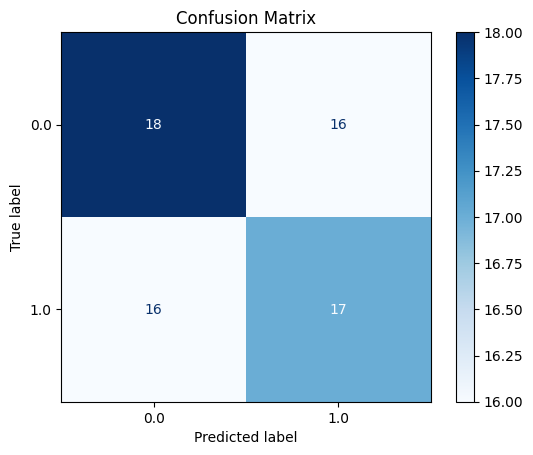

Test Accuracy: 0.5224


In [2617]:
res_df = get_res_df(reg_df, y_pred_sin, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Time Series (Not Possible with the Spike Exclusive Data

#### Neural Network

##### Strategy I: Direct Classification (Neural Network)

###### Initial Model

In [2622]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [59]:
# num_epochs = 20
# batch_size = 32

# model = Sequential([
#     Dense(16, input_dim=X.shape[1], activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(32, activation='relu'),
#     Dropout(0.5),  # Dropout layer for regularization
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation ==> binary classification
# ])

# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

# history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

# train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
# test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

# print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
# print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

### This is the best model I have gotten so far
model_path = './models/nn_buy_cotton_classification_model_1_062224_full_data_offset1.pkl'

# Load the model
with open(model_path, 'rb') as f:
    model = pickle.load(f)
    
num_epochs = 4
batch_size = 32
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Train Accuracy: 0.6794, Train Loss: 0.6039
Test Accuracy: 0.7083, Test Loss: 0.5957


3/3 [==============================] - 0s 2ms/step


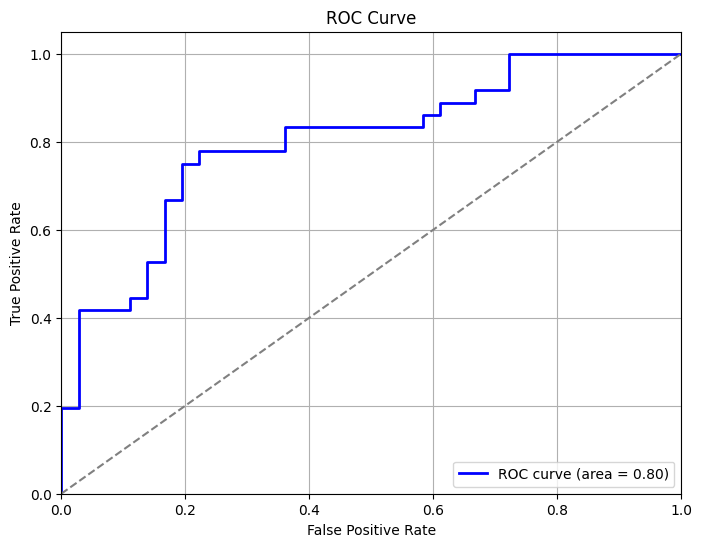

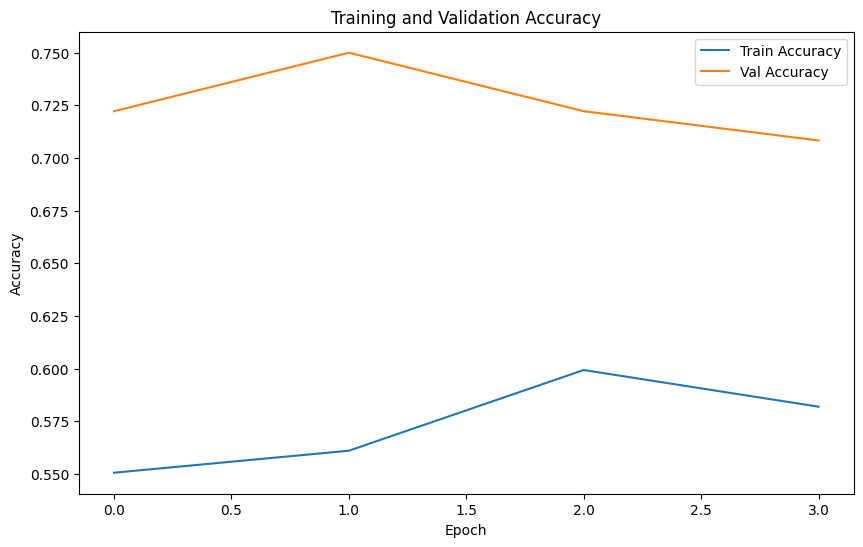

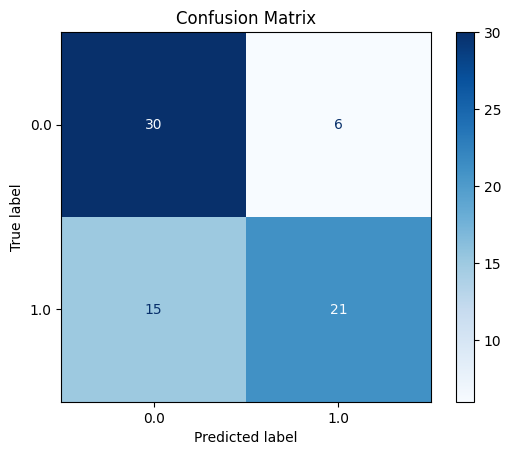

In [60]:
### Predictions
threshold = 0.5
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

###### Hyperparmeter-Tuned Model 

Since `RandomizedSearchCV` & `GridSearchCV` were giving me issues, I manually finetuned the hyperparameters.

In [2627]:
n_iter = 100
X = X_train.values
y = y_train.values
param_dist = {
    'learning_rate': uniform(0.001, 0.1),  
    'dropout_rate': uniform(0, 0.7),     
    'num_layers': [1, 2, 3],               
    'num_nodes': [16, 32, 64],             
    'epochs': [10, 20, 30, 40],                
    'batch_size': [16, 32, 64]             
}
best_model, best_params = RandomCV(X, y, param_dist, reg = False, n_iter = n_iter, cv = 4, random_state = 29)

Iteration 1/100
Sampled parameters: {'learning_rate': 0.0873759985570083, 'dropout_rate': 0.19943417565933874, 'num_layers': 3, 'num_nodes': 16, 'epochs': 10, 'batch_size': 32}
Mean CV score: 0.4821
Iteration 2/100
Sampled parameters: {'learning_rate': 0.04627190575994114, 'dropout_rate': 0.3796078118061421, 'num_layers': 2, 'num_nodes': 64, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.4786
Iteration 3/100
Sampled parameters: {'learning_rate': 0.07781999778089822, 'dropout_rate': 0.5132006063240122, 'num_layers': 1, 'num_nodes': 64, 'epochs': 40, 'batch_size': 16}
Mean CV score: 0.5286
Iteration 4/100
Sampled parameters: {'learning_rate': 0.0068377305811721184, 'dropout_rate': 0.28676824831044895, 'num_layers': 3, 'num_nodes': 16, 'epochs': 30, 'batch_size': 16}
Mean CV score: 0.5107
Iteration 5/100
Sampled parameters: {'learning_rate': 0.0850919735388559, 'dropout_rate': 0.5664073940705749, 'num_layers': 3, 'num_nodes': 64, 'epochs': 20, 'batch_size': 64}
Mean CV score: 0.4714
Ite

Train Accuracy: 0.9929, Train Loss: 0.0222
Test Accuracy: 0.4857, Test Loss: 15.3501
3/3 [==============================] - 0s 3ms/step


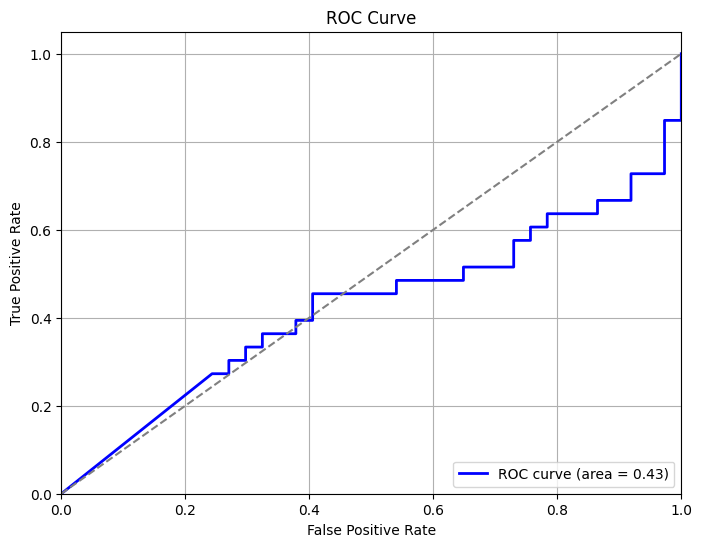

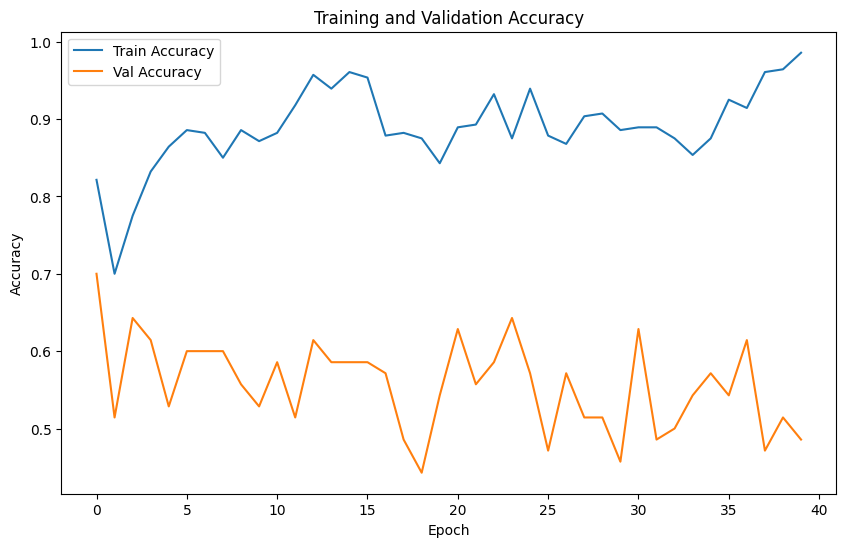

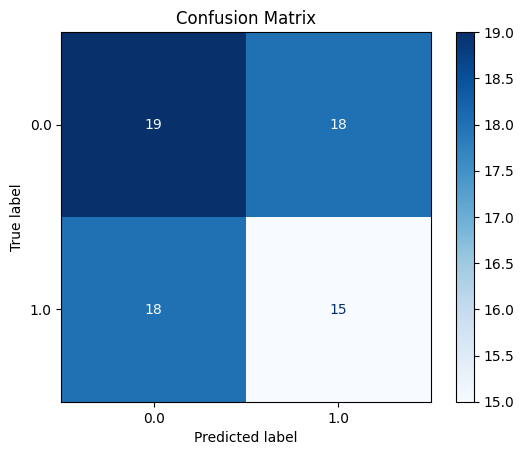

In [2628]:
#### Performance Evaluation
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, y_test), verbose = 0)

train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose = 0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose = 0)

print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

threshold = 0.5
y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba >= threshold).astype(int)

### ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

### Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

##### Strategy II: Predict price (using Neural Network) then use price to classify

###### Initial Model

In [2631]:
### Ensures I am working with "clean slate"
tf.keras.backend.clear_session()

In [2650]:
num_epochs = 20
batch_size = 32

model = Sequential([
    Dense(16, input_dim=X.shape[1], activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(32, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(16, activation='relu'),
    Dense(1)  # No activation ==> Regression
])

model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')

model.summary()

history = model.fit(reg_X_train, reg_y_num_train, epochs = num_epochs, batch_size = batch_size, validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_nn = model.predict(reg_X_test)
mse = mean_squared_error(reg_y_num_test, y_pred_nn)

print(f"Mean Squared Error on Test Set: {mse}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                13792     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                544       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 14881 (58.13 KB)
Trainable params: 14881

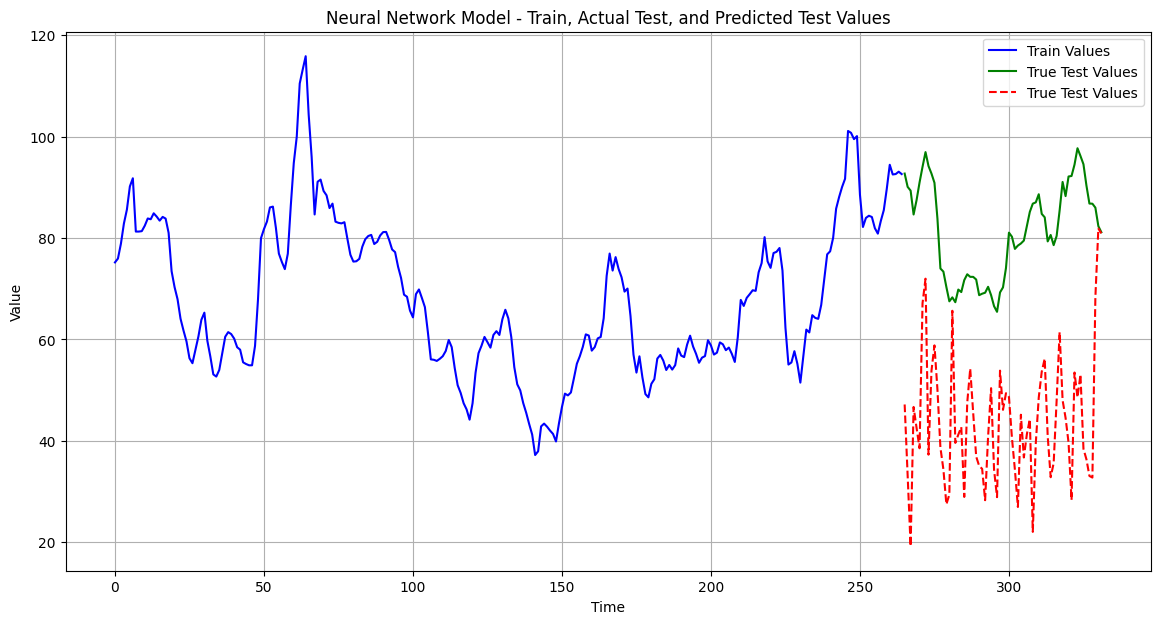

In [2654]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(reg_y_num_train)), reg_y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), reg_y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(reg_y_num_train), len(reg_y_num_train) + len(reg_y_num_test)), y_pred_nn, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

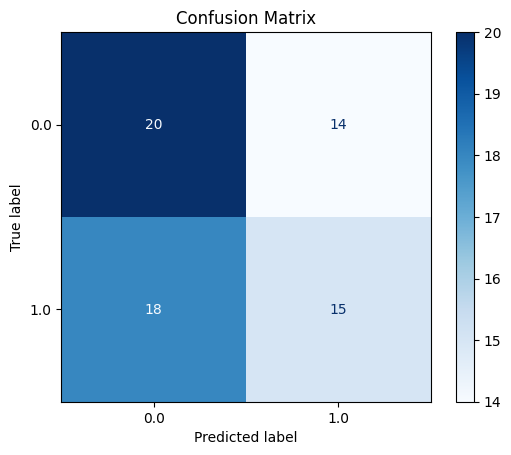

Test Accuracy: 0.5224


In [2656]:
res_df = get_res_df(reg_df, y_pred_nn.flatten(), idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparmeter-Tuned Model

In [ ]:
X = X_train.values
y = y_num_train.values
best_model, best_params = RandomCV(X, y, param_dist, reg = True, n_iter = n_iter, cv = 4, random_state = 29)

In [ ]:
history = best_model.fit(reg_X_train, reg_y_num_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(reg_X_test, reg_y_test), verbose = 0)

y_pred_best_model = best_model.predict(reg_X_test)
mse_best_model = mean_squared_error(reg_y_num_test, y_pred_best_model)

print(f"Mean Squared Error on Test Set: {mse}")

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_best_model, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Best Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
res_df = get_res_df(reg_df, y_pred_best_model, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

#### Random Forrest

##### Strategy I: Direct Classification (Random Forrest)

###### Initial Model

In [61]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state = 29)

# Train the model
rf_classifier.fit(reg_X_train, reg_y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(reg_X_test)

# Evaluate the model
accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.6376811594202898
Confusion Matrix:



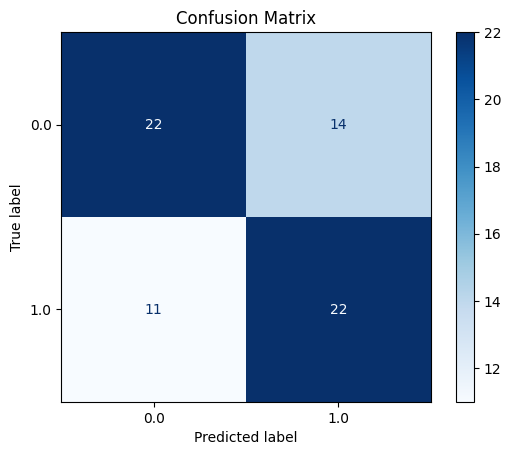

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.61      0.64        36
         1.0       0.61      0.67      0.64        33

    accuracy                           0.64        69
   macro avg       0.64      0.64      0.64        69
weighted avg       0.64      0.64      0.64        69



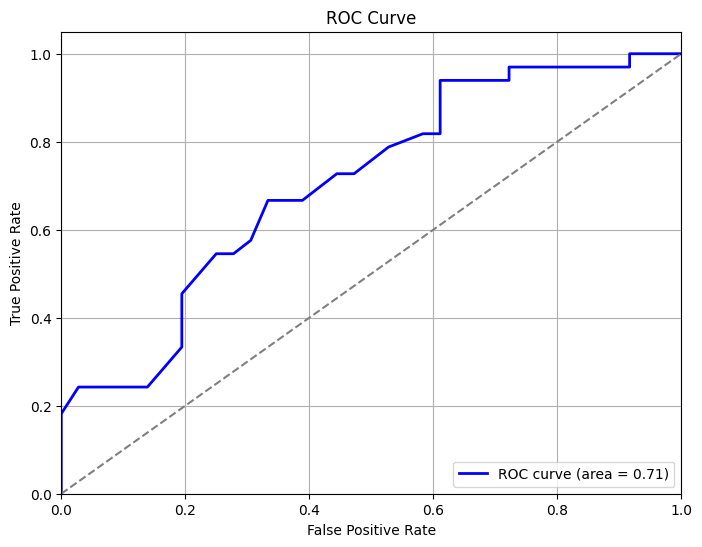

In [62]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = rf_classifier.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

###### Hyperparamter-Tuned Model

In [63]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, 4),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}


# Create the Random Forest Classifier
rf_class = RandomForestClassifier(random_state = 29)

# Perform Randomized Search Cross-Validation
random_search_rf_class = RandomizedSearchCV(rf_class, param_distributions = param_dist, n_iter = 100, cv = 10, verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_class.fit(reg_X_train, reg_y_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_class.best_params_)
best_rf_class = random_search_rf_class.best_estimator_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 115}


In [64]:
y_pred_rf = best_rf_class.predict(reg_X_test)

accuracy = accuracy_score(reg_y_test, y_pred_rf)
cm = confusion_matrix(reg_y_test, y_pred_rf)
class_report = classification_report(reg_y_test, y_pred_rf)

Test Accuracy: 0.6666666666666666
Confusion Matrix:



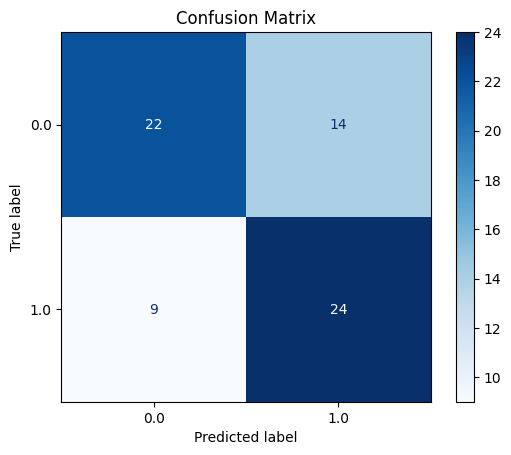

Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.61      0.66        36
         1.0       0.63      0.73      0.68        33

    accuracy                           0.67        69
   macro avg       0.67      0.67      0.67        69
weighted avg       0.67      0.67      0.67        69



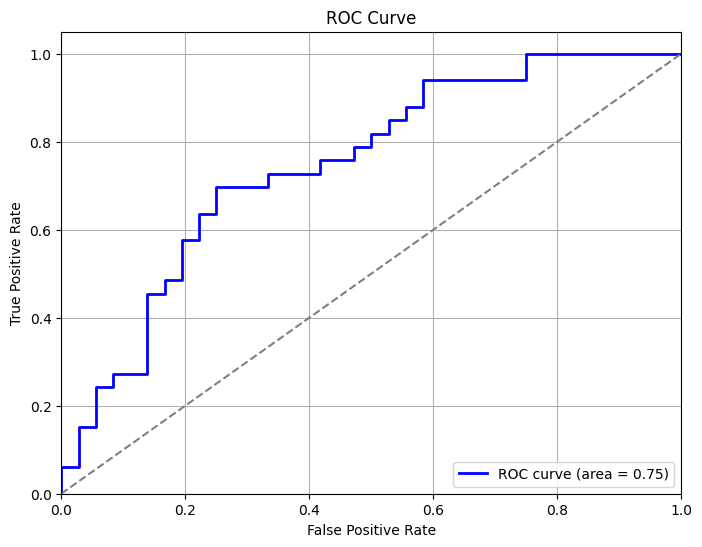

In [65]:
print("Test Accuracy:", accuracy)
print("Confusion Matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()
print("Classification Report:\n", class_report)

y_pred_proba = best_rf_class.predict_proba(reg_X_test)
y_pred_proba = [p[1] for p in y_pred_proba]
### ROC curve
fpr, tpr, thresholds = roc_curve(reg_y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show();

In [ ]:
# ## Uncomment when a new model is to be added
# ## MAKE SURE TO CHANGE THE PATH FIRST!!!
# model_path = './models/rf_buy_cotton_classification_model_2_no_spike_062424.pkl'

    
# with open(model_path, 'wb') as file:
#     pickle.dump(best_rf_class, file)

##### Strategy II: Predict price (using Random Forrest) then use price to classify

###### Initial Model

In [ ]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

rf_regressor.fit(reg_X_train, reg_y_num_train)

y_pred_rf = rf_regressor.predict(reg_X_test)

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# accuracy = accuracy_score(reg_y_test, y_pred_rf)
# cm = confusion_matrix(reg_y_test, y_pred_rf)
# class_report = classification_report(reg_y_test, y_pred_rf)

In [ ]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')

###### Hyperparamter-Tuned Model

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [3, None],
    'max_features': randint(1, X.shape[1]),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 29)

random_search_rf_reg = RandomizedSearchCV(rf_regressor, param_distributions = param_dist, n_iter = n_iter, cv = 4,
                                   verbose = 2, random_state = 29, n_jobs=-1)
random_search_rf_reg.fit(reg_X_train, reg_y_num_train)

# Best parameters and estimator
print("Best parameters found: ", random_search_rf_reg.best_params_)
best_rf_reg = random_search_rf_reg.best_estimator_

In [ ]:
y_pred_rf = best_rf_reg.predict(reg_X_test)

plt.figure(figsize=(14, 7))

plt.plot(np.arange(len(y_num_train)), y_num_train, label='Train Values', color='blue')

# Plot testing data (actual values)
plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_num_test, label='True Test Values', color='green')

plt.plot(np.arange(len(y_num_train), len(y_num_train) + len(y_num_test)), y_pred_rf, label='True Test Values', color='red', ls = '--')

plt.title('Neural Network Model - Train, Actual Test, and Predicted Test Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
res_df = get_res_df(reg_df, y_pred_rf, idx = reg_X_test.index)

cm = confusion_matrix(res_df['buy_true'], res_df['buy_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Test Accuracy
accuracy = accuracy_score(res_df['buy_true'], res_df['buy_pred'])
print(f'Test Accuracy: {accuracy:.4f}')